#### OPENCLASSROOMS - Parcours Data Scientist  
## Projet 5: Segmentez des clients d'un site e-commerce  
Etudiant: Eric Wendling  
Mentor: Julien Heiduk  
Date: 07/04/2020

**TABLE DES MATIERES**

#### [Présentation du projet](#pre_pro)

#### [Partie 1: Analyse et Extractions de caractéristiques](#pre_pro)

#### [Initialisation](#ini)
 
* [Import des modules Python](#imp_mod_pyt)
* [Fonctions](#fon)
* [Récupération des données](#rec_don)

#### [Analyse exploratoire des données](#ana_exp_don)

* [Fusion 1: Commandes / Evaluations](#fus_1)
* [Fusion 2: Clients / Commandes](#fus_2)
* [Fusion 3: Items / Produits](#fus_3)
* [Fusion 4: Clients/Commandes / Items/Produits](#fus_4)
* [Fusion 5: Commandes / Paiements](#fus_5)

#### [Modèle de données](#mod_don)

* [Traitement des données](#tra_don)
* [Dataframe df - Niveau Lignes de commandes](#dat_df)
* [Dataframe df1 - Niveau Client](#dat_df1)
* [Fonctions de recherche par client](#fon_rec)

## Présentation du projet <a class="anchor" id="pre_pro"></a>

La société **olist** offre des services de commerce électronique en mode B2C via une plateforme de vente en ligne.  
Elle gère donc à la fois des **vendeurs** de produits divers et des acheteurs qui représentent les **clients**.

>Son objectif est l'optimisation des campagnes de communication marketing destinées aux **clients**.

Pour cela, **olist** souhaite réaliser une ***Segmentation de marché*** des clients.

Il existe de nombreuses méthodes de segmentation de marché, une méthode bien connue étant la segmentation RFM.  
Une seconde approche consiste à réaliser des groupes de clients avec des méthodes de classification automatiques non supervisées.

L'ensemble des transactions est géré dans une base de données qui contient les données relatives aux clients, aux commandes, aux produits et aux vendeurs.

Dans cette étude, nous allons dans un premier temps exploiter ces données pour une réaliser une **Segmentation RFM**.

Une seconde partie sera consacrée à la classification automatique des clients avec des méthodes de **Clustering** (non supervisées).


Les différents traitements sont répartis dans 2 notebooks:

+ Partie 1: Analyse et Extractions des caractéristiques
+ Partie 2: Segmentation RFM et Classification automatique

## Partie 1: Analyse et Extractions de caractéristiques <a class="anchor" id="par_1"></a>

## Initialisation <a class="anchor" id="ini"></a>

### Import des modules Python <a class="anchor" id="imp_mod_pyt"></a>

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
print('Pandas version:',pd.__version__)
pd.options.mode.chained_assignment = None

import numpy as np

import matplotlib
print('Matplotlib version:',matplotlib.__version__)

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
print('Seaborn version:',sns.__version__)
sns.set(style="darkgrid")

from IPython.display import Image, HTML
from sklearn.metrics.pairwise import linear_kernel

import tqdm
import time
from time import strftime, gmtime
import sys

from pprint import pprint

import squarify

from IPython.display import Markdown

Pandas version: 1.0.3
Matplotlib version: 3.2.1
Seaborn version: 0.10.1


### Fonctions <a class="anchor" id="fon"></a>

La fonction ci-dessous permet de mesurer le temps de traitement d'une opération et donne la durée totale des traitements mesurés.

In [2]:
list_elapsed = []
list_ope = []

def time_calc(ope='dernière operation',print_all=0):
    elapsed = round((time.time() - t),2)
    if ope != 'dernière operation':
        print('Durée de l\'opération %r:' %ope, round(elapsed,2),'s')
    else:
        print('Durée de l\'opération:', round(elapsed,2),'s')
    list_elapsed.extend([elapsed])
    list_ope.extend([ope])
    tot_duration = sum(list_elapsed)
    df_time = pd.DataFrame({'Opération': list_ope, 'Durée': list_elapsed})

    print('Durée totale de traitement:',strftime('%H', gmtime(tot_duration)),'h',
          strftime('%M', gmtime(tot_duration)),'m',strftime('%S', gmtime(tot_duration)),'s')
    if print_all == 1:
        title('Durée des opérations')
        print(df_time)   

In [3]:
# Démarrage du compteur
t = time.time()

La fonction suivante donne des informations statistiques sur les taux de remplissage d'une colonne ou d'une ligne.

In [4]:
def stats(df_ref,axis_ref,var_select='p_val',critical_level=0):    
    """Statistiques descriptives des colonnes ou des lignes"""
    
    df = pd.DataFrame(df_ref.notnull().sum(axis=axis_ref), columns = ["nb_val"])
    # On définit un index
    df = df.reset_index()
    # On ajoute une variable: le pourcentage de remplissage
    df['p_val'] = df['nb_val'] * 100 / df_ref.shape[axis_ref]    
    # On identifie les colonnes (ou lignes) dont le taux est supérieur ou égal au seuil
    df = df[(df[var_select] >= critical_level)]
    df = df.sort_values(by = var_select, ascending = False)
    df = df.round(1)
    print(df[['nb_val','p_val']].describe())
    print('')
    if axis_ref == 0:
        print('50% des variables ont un taux de remplissage inférieur à',df['p_val'].median(),'%')
    else:
        print('50% des lignes ont un taux de remplissage inférieur à',df['p_val'].median(),'%')
    df['p_val'].plot(kind='box', figsize=(3,4), color="black")

La fonction suivante montre les taux de remplissage d'un ensemble de variables.

In [5]:
def fill_rate(df,v_min=0,v_max=1,n=5):    
    """Taux de remplissage des variables"""
    
    f_rate = 'Taux de remplissage (%)'
    
    df_fill_rate = df.notnull().mean(axis=0)
    df_fill_rate = pd.DataFrame(df_fill_rate, columns = [f_rate])
    df_fill_rate = df_fill_rate[(df_fill_rate[f_rate] >= v_min) & (df_fill_rate[f_rate] <= v_max)]
    df_fill_rate = df_fill_rate.sort_values(by = f_rate, ascending=True)
    df_fill_rate = round(df_fill_rate * 100,3)
    
    print('')
    print('Affichage des %r premières variables triées par taux croissant:' % n)
    print('')
    print(df_fill_rate.head(n))
    
    plt.figure(figsize=(5,n/3))
    df_fill_rate[f_rate].head(n).plot.barh()
    plt.title("Taux de remplissage par variable")
    plt.show()

La fonction ci-dessous permet d'identifier les valeurs abberantes (outliers) d'une variable.

In [6]:
def val_out(df_ref,var_01,var_01_max='',var_01_min=0):
    """Fonction d'identification de valeurs abberantes"""
    
    df = df_ref.copy()
    df = df[[var_01]]
    
    if var_01_max != '':
        df = df[(df[var_01] >= var_01_min) & (df[var_01] <= var_01_max)]
    else:
        df = df
    
    print(df.describe())  
    df.plot(kind='box', figsize=(3,4), color="black")

La fonction suivante permet d'écrire un titre sous-ligné.

In [7]:
def title(title):
    print('')
    print(title)
    print(len(title)*'-')    

In [8]:
def bip():
    import winsound
    frequency = 440  # max 2500 Hertz
    duration = 400  # max 1000 ms
    winsound.Beep(frequency, duration)

In [9]:
time_calc('Initialisation')
t = time.time()

Durée de l'opération 'Initialisation': 0.09 s
Durée totale de traitement: 00 h 00 m 00 s


### Récupération des données <a class="anchor" id="rec_don"></a>

In [10]:
get_data = 0

if get_data == 0: # Import des données à partir des fichiers csv et stockage des dataframes   
       
    df_customers = pd.read_csv('data/olist_customers_dataset.csv',encoding='utf-8',low_memory=False)
    df_geolocation = pd.read_csv('data/olist_geolocation_dataset.csv',encoding='utf-8',low_memory=False)
    df_order_items = pd.read_csv('data/olist_order_items_dataset.csv',encoding='utf-8',low_memory=False)
    df_order_payments = pd.read_csv('data/olist_order_payments_dataset.csv',encoding='utf-8',low_memory=False)
    df_order_reviews = pd.read_csv('data/olist_order_reviews_dataset.csv',encoding='utf-8',low_memory=False)
    df_orders = pd.read_csv('data/olist_orders_dataset.csv', encoding='utf-8',low_memory=False)
    df_products = pd.read_csv('data/olist_products_dataset.csv',encoding='utf-8',low_memory=False)
    df_sellers = pd.read_csv('data/olist_sellers_dataset.csv',encoding='utf-8',low_memory=False)
    df_product_category_name_translation = pd.read_csv('data/product_category_name_translation.csv',
                                                       encoding='utf-8',low_memory=False)
   
    %store df_customers
    %store df_geolocation
    %store df_order_items
    %store df_order_payments
    %store df_order_reviews
    %store df_orders
    %store df_products
    %store df_sellers
    %store df_product_category_name_translation
    
elif get_data == 1: # On rafraîchit les dataframes depuis le store
            
    %store -r df_customers
    %store -r df_geolocation
    %store -r df_order_items
    %store -r df_order_payments
    %store -r df_order_reviews
    %store -r df_orders
    %store -r df_products
    %store -r df_sellers
    %store -r df_product_category_name_translation

Stored 'df_customers' (DataFrame)
Stored 'df_geolocation' (DataFrame)
Stored 'df_order_items' (DataFrame)
Stored 'df_order_payments' (DataFrame)
Stored 'df_order_reviews' (DataFrame)
Stored 'df_orders' (DataFrame)
Stored 'df_products' (DataFrame)
Stored 'df_sellers' (DataFrame)
Stored 'df_product_category_name_translation' (DataFrame)


In [11]:
time_calc('Récupération des données')
t = time.time()

Durée de l'opération 'Récupération des données': 3.19 s
Durée totale de traitement: 00 h 00 m 03 s


## Analyse exploratoire des données <a class="anchor" id="ana_exp_don"></a>

In [12]:
list_dataset = []
list_shape = []
list_variable = []
list_duplicates = []
list_unique = []
list_null = []

dic_data_model = {'Dataset': list_dataset,
                  'Shape': list_shape,
                  'Variable': list_variable,
                  'Duplicates': list_duplicates,
                  'Unique': list_unique,
                  'Null': list_null}

def data_model(df,df_name,var,print_=0,n=5):
    
    list_dataset.append(df_name)
    list_shape.append(df.shape[0])
    list_variable.append(var)
    list_duplicates.append(df.duplicated(subset=[var]).sum())
    list_unique.append(df[var].unique().shape[0])
    list_null.append(df[var].isna().sum().sum())
    
    df_data_model = pd.DataFrame(dic_data_model)
    
    if print_ == 1:
        return df_data_model.tail(n)

In [13]:
def data_model_2(df1,df2,df1_name,df2_name,left_on_,right_on_):
    
    df1_left = df1.merge(df2, left_on = left_on_, right_on = right_on_, how = 'left').sort_values(right_on_)
    
    df1_rows = df1.merge(df2, left_on = left_on_, right_on = right_on_, how = 'left').shape[0]
    df2_rows = df1.merge(df2, left_on = left_on_, right_on = right_on_, how = 'right').shape[0]
    shared_rows = df1.merge(df2, left_on = left_on_, right_on = right_on_, how = 'inner').shape[0]
    left_rows = df1_rows - shared_rows
    right_rows = df2_rows - shared_rows
    
    print('Nombre d\'enregistrements du dataset %r non renseignés dans le dataset %r: %r' % (df1_name, df2_name, left_rows))
    print('Nombre d\'enregistrements du dataset %r non renseignés dans le dataset %r: %r' % (df2_name, df1_name, right_rows))

### Fusion 1: Commandes / Evaluations <a class="anchor" id="fus_1"></a>

#### Dataset - orders

In [14]:
df_orders.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


On supprime les variables qui ne nous intéressent pas.

In [15]:
del df_orders['order_approved_at']
del df_orders['order_delivered_carrier_date']
del df_orders['order_delivered_customer_date']
del df_orders['order_estimated_delivery_date']

In [16]:
data_model(df_orders,'orders','order_id',1)

,Dataset,Shape,Variable,Duplicates,Unique,Null
0,orders,99441,order_id,0,99441,0


#### Dataset - order_reviews

In [17]:
df_order_reviews.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   review_id                100000 non-null  object
 1   order_id                 100000 non-null  object
 2   review_score             100000 non-null  int64 
 3   review_comment_title     11715 non-null   object
 4   review_comment_message   41753 non-null   object
 5   review_creation_date     100000 non-null  object
 6   review_answer_timestamp  100000 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


On supprime les variables qui ne nous intéressent pas.

In [18]:
del df_order_reviews['review_comment_title']
del df_order_reviews['review_comment_message']
del df_order_reviews['review_creation_date']
del df_order_reviews['review_answer_timestamp']

In [19]:
data_model(df_order_reviews,'order_reviews','review_id',1)

,Dataset,Shape,Variable,Duplicates,Unique,Null
0,orders,99441,order_id,0,99441,0
1,order_reviews,100000,review_id,827,99173,0


La variable **'review_id'** n'est pas unique, il ne s'agit donc pas d'une clé primaire.

#### orders vs order_reviews

In [20]:
data_model(df_order_reviews,'order_reviews','order_id',1)

,Dataset,Shape,Variable,Duplicates,Unique,Null
0,orders,99441,order_id,0,99441,0
1,order_reviews,100000,review_id,827,99173,0
2,order_reviews,100000,order_id,559,99441,0


In [21]:
data_model_2(df_order_reviews,df_orders,'order_reviews','orders','order_id','order_id')

Nombre d'enregistrements du dataset 'order_reviews' non renseignés dans le dataset 'orders': 0
Nombre d'enregistrements du dataset 'orders' non renseignés dans le dataset 'order_reviews': 0


+ A chaque enregistrement de ***orders*** correspond 1 ou plusieurs enregistrements de ***order_reviews***.
+ A chaque enregistrement de ***order_reviews*** correspond 1 et 1 seul enregistrement de ***orders***.

**Etape préliminaire:** On cherche à associer une note (**'review_score'**) unique à chaque commande.

Chaque commande peut faire l'objet de plusieurs notes.

> On regroupe les notes par commande en faisant la moyenne des notes (**'review_score'**).

In [22]:
df_order_reviews_gr = df_order_reviews.groupby('order_id').agg({'review_score': ['mean','count']}).sort_values(('review_score','count'),ascending=False)
df_order_reviews_gr = df_order_reviews_gr.reset_index()

# On renomme les colonnes
df_order_reviews_gr.columns = ['order_id','score_mean_per_ord','score_count_per_ord']
df_order_reviews_gr.head()

,order_id,score_mean_per_ord,score_count_per_ord
0,c88b1d1b157a9999ce368f218a407141,4.333333,3
1,8e17072ec97ce29f0e1f111e598b0c85,1.000000,3
2,03c939fd7fd3b38f8485a0f95798f1f6,3.333333,3
3,df56136b8031ecd28e200bb18e6ddb2e,5.000000,3
4,c63031aab37b1beb849bb4856afd4f13,5.000000,2


#### orders vs order_reviews_gr

In [23]:
data_model(df_order_reviews_gr,'order_reviews_gr','order_id',1)

,Dataset,Shape,Variable,Duplicates,Unique,Null
0,orders,99441,order_id,0,99441,0
1,order_reviews,100000,review_id,827,99173,0
2,order_reviews,100000,order_id,559,99441,0
3,order_reviews_gr,99441,order_id,0,99441,0


> La dataset ***order_reviews_gr*** contient maintenant 99441 valeurs uniques pour la variable **'order_id'**.

In [24]:
data_model_2(df_order_reviews_gr,df_orders,
             'order_reviews_gr','orders',
             'order_id','order_id')

Nombre d'enregistrements du dataset 'order_reviews_gr' non renseignés dans le dataset 'orders': 0
Nombre d'enregistrements du dataset 'orders' non renseignés dans le dataset 'order_reviews_gr': 0


#### Fusion orders / order_reviews

Chaque commande est maintenant relié à 1 et 1 seul enregistrement du dataset ***'order_reviews_gr'***.

> On fusionne donc les datasets ***orders*** et ***order_reviews_gr*** avec une contrainte de correspondance nécessaire (inner join).

In [25]:
df_orders = df_orders.merge(df_order_reviews_gr, left_on = 'order_id', right_on = 'order_id', how = 'inner')
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  99441 non-null  object 
 1   customer_id               99441 non-null  object 
 2   order_status              99441 non-null  object 
 3   order_purchase_timestamp  99441 non-null  object 
 4   score_mean_per_ord        99441 non-null  float64
 5   score_count_per_ord       99441 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 5.3+ MB


In [26]:
data_model(df_orders,'orders','order_id',1,3)

,Dataset,Shape,Variable,Duplicates,Unique,Null
2,order_reviews,100000,order_id,559,99441,0
3,order_reviews_gr,99441,order_id,0,99441,0
4,orders,99441,order_id,0,99441,0


In [27]:
time_calc('Fusion 1: Commandes / Evaluations')
t = time.time()

Durée de l'opération 'Fusion 1: Commandes / Evaluations': 2.28 s
Durée totale de traitement: 00 h 00 m 05 s


In [28]:
print('Dimensions df_orders',df_customers.shape)

Dimensions df_orders (99441, 5)


### Fusion 2: Clients / Commandes <a class="anchor" id="fus_2"></a>

#### Dataset - geolocation

In [29]:
df_geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [30]:
data_model(df_geolocation,'geolocation','geolocation_zip_code_prefix',1,1)

,Dataset,Shape,Variable,Duplicates,Unique,Null
5,geolocation,1000163,geolocation_zip_code_prefix,981148,19015,0


In [31]:
geolocation_shape = df_geolocation.shape[0]
geolocation_unique = df_geolocation['geolocation_zip_code_prefix'].unique().shape[0]

In [32]:
Markdown("""
La variable **'geolocation_zip_code_prefix'** du dataset ***geolocation*** compte **{geolocation_unique}** valeurs uniques sur **{geolocation_shape}**. 
""".format(geolocation_unique=geolocation_unique,geolocation_shape=geolocation_shape))


La variable **'geolocation_zip_code_prefix'** du dataset ***geolocation*** compte **19015** valeurs uniques sur **1000163**. 


Elle ne représente donc pas une clé primaire.

> On regroupe alors les enregistrements sur la variable **'geolocation_zip_code_prefix'** et on réalise la moyenne des coordonnées géographiques.

In [33]:
df_geolocation_gr_0 = df_geolocation.groupby('geolocation_zip_code_prefix').agg({'geolocation_lat': 'mean',
                                                                               'geolocation_lng': 'mean',
                                                                               'geolocation_city': 'first',
                                                                               'geolocation_state': 'first'})

df_geolocation_gr_0 = df_geolocation_gr_0.reset_index()

In [34]:
data_model(df_geolocation_gr_0,'geolocation_gr_0','geolocation_zip_code_prefix',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
5,geolocation,1000163,geolocation_zip_code_prefix,981148,19015,0
6,geolocation_gr_0,19015,geolocation_zip_code_prefix,0,19015,0


In [35]:
%store df_geolocation_gr_0

Stored 'df_geolocation_gr_0' (DataFrame)


#### Dataset - customers

In [36]:
df_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Les enregistrements du dataset ***customers*** sont reliés au dataset ***geolocation_gr_0*** par les variables **'customer_zip_code_prefix'** et **'geolocation_zip_code_prefix'**.

In [37]:
data_model(df_customers,'customers','customer_zip_code_prefix',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
6,geolocation_gr_0,19015,geolocation_zip_code_prefix,0,19015,0
7,customers,99441,customer_zip_code_prefix,84447,14994,0


#### customers vs geolocation_gr_0

In [38]:
data_model_2(df_customers,df_geolocation_gr_0,
             'customers','geolocation_gr_0',
             'customer_zip_code_prefix','geolocation_zip_code_prefix')

Nombre d'enregistrements du dataset 'customers' non renseignés dans le dataset 'geolocation_gr_0': 278
Nombre d'enregistrements du dataset 'geolocation_gr_0' non renseignés dans le dataset 'customers': 4178


+ A un enregistrement de ***customers*** correspond 0 ou 1 enregistrement de ***geolocation_gr_0***.
+ A un enregistrement de ***geolocation_gr_0*** correspondent 0 ou plusieurs enregistrements de ***customers***.

#### Fusion - customers / geolocation_gr_0

Les références client n'ont pas toutes de correspondance dans le dataset ***geolocation_gr_0***.

> On fusionne donc les datasets ***customers*** et ***geolocation_gr_0*** avec une contrainte de correspondance facultative sur ***geolocation_gr_0***  (left join).

In [39]:
df_customers = df_customers.merge(df_geolocation_gr_0, left_on = 'customer_zip_code_prefix', 
                                  right_on = 'geolocation_zip_code_prefix', how = 'left')

In [40]:
df_customers[['customer_zip_code_prefix','geolocation_zip_code_prefix']].sort_values('geolocation_zip_code_prefix', ascending = True)

,customer_zip_code_prefix,geolocation_zip_code_prefix
23914,1003,1003.0
11747,1004,1004.0
23990,1004,1004.0
12307,1005,1005.0
71571,1005,1005.0
...,...,...
97467,72338,NaN
97780,68629,NaN
98140,28530,NaN
98878,55863,NaN


##### Cohérence des informations de localisation

On vérifie si les valeurs de ville et d'état du dataset ***customers*** correspondent à celles du dataset ***geolocation_gr_0*** par la relation entre les variables **'customer_zip_code_prefix'** et **'geolocation_zip_code_prefix'**.

In [41]:
df_cust_loc_ctrl = df_customers.copy()
df_cust_loc_ctrl = df_cust_loc_ctrl.dropna()

Le programme ci-dessous transforme les valeurs des variables relatives aux **villes** et **états** en valeurs **non accentuées**, dans le but de les comparer.

In [42]:
import unidecode

list_customer_city = df_cust_loc_ctrl['customer_city'].values.tolist()
list_geolocation_city = df_cust_loc_ctrl['geolocation_city'].values.tolist()

list_customer_city_2 = []

for acc_val in list_customer_city:
    # On transforme les valeurs en valeurs non accentuées
    unacc_val = unidecode.unidecode(acc_val)
    list_customer_city_2.append(unacc_val)

# On remplace les valeurs de 'customer_city' par les valeurs non-accentuées de la liste list_customer_city_2
df_cust_loc_ctrl = df_cust_loc_ctrl.assign(customer_city = list_customer_city_2)

list_geolocation_city_2 = []

for acc_val in list_geolocation_city:
    unacc_val = unidecode.unidecode(acc_val)
    list_geolocation_city_2.append(unacc_val)
    
df_cust_loc_ctrl = df_cust_loc_ctrl.assign(geolocation_city = list_geolocation_city_2)

In [43]:
df_cust_loc_ctrl[['customer_id','customer_city','customer_state','geolocation_city','geolocation_state']].sort_values('customer_id').head()

,customer_id,customer_city,customer_state,geolocation_city,geolocation_state
84790,00012a2ce6f8dcda20d059ce98491703,osasco,SP,osasco,SP
27335,000161a058600d5901f007fab4c27140,itapecerica,MG,itapecerica,MG
63792,0001fd6190edaaf884bcaf3d49edf079,nova venecia,ES,nova venecia,ES
97756,0002414f95344307404f0ace7a26f1d5,mendonca,MG,mendonca,MG
59921,000379cdec625522490c315e70c7a9fb,sao paulo,SP,sao paulo,SP


In [44]:
df_cust_loc_ctrl['compare'] = np.where(df_cust_loc_ctrl['customer_city'] == df_cust_loc_ctrl['geolocation_city'],1,0)
df_cust_loc_ctrl[df_cust_loc_ctrl['compare'] == 0].shape[0]

337

Les valeurs ne correspondent pas pour 337 références client.

Nous n'avons pas les moyens de savoir quelles sont les valeurs justes.

> Nous prenons comme référence les informations associées aux coordonnées géographiques.

> A ce stade, il n'est plus utile de disposer des valeurs de coordonnées géographiques, villes et états dans le dataframe pour la suite de l'analyse. En effet, la connaissance des prefix est suffisante.
>
>Lorsque nous aurons besoin de connaître les informations géographiques à partir des prefix, nous pourrons faire appel à tout moment une fusion avec le dataset ***geolocation_gr_0***.

In [45]:
del df_customers['customer_city']
del df_customers['customer_state']
del df_customers['geolocation_lat']
del df_customers['geolocation_lng']
del df_customers['geolocation_city']
del df_customers['geolocation_state']

Pour la suite de l'analyse, nous définissons également un nouveau dataset ***geolocation_gr*** qui ne contient que l'index des préfixes.

In [46]:
df_geolocation_gr = df_geolocation_gr_0[['geolocation_zip_code_prefix']]
df_geolocation_gr.head()

,geolocation_zip_code_prefix
0,1001
1,1002
2,1003
3,1004
4,1005


##### Unicité des informations de localisation par rapport aux clients uniques

In [47]:
df_cust_loc = df_customers.groupby('customer_unique_id').agg({
    'customer_zip_code_prefix': ['first','sum','count']}).sort_values(('customer_zip_code_prefix','count'),ascending=False)

df_cust_loc['zip_control'] = (df_cust_loc[('customer_zip_code_prefix','sum')] / 
                       df_cust_loc[('customer_zip_code_prefix','count')]) - df_cust_loc[('customer_zip_code_prefix','first')]

df_cust_loc[df_cust_loc['zip_control'] != 0].head()

customer_zip_code_prefix                \
                                                    first     sum count   
customer_unique_id                                                        
47c1a3033b8b77b3ab6e109eb4d5fdf3                     6634   39794     6   
f34cd7fd85a1f8baff886edf09567be3                    89120  356467     4   
738ffcf1017b584e9d2684b36e07469c                    74440  278990     4   
b9badb100ff8ecc16a403111209e3a06                     3014  179124     3   
bf6656ef50e6fd00e7517b01d615b4f3                    29104   87310     3   

                                   zip_control  
                                                
customer_unique_id                              
47c1a3033b8b77b3ab6e109eb4d5fdf3     -1.666667  
f34cd7fd85a1f8baff886edf09567be3     -3.250000  
738ffcf1017b584e9d2684b36e07469c  -4692.500000  
b9badb100ff8ecc16a403111209e3a06  56694.000000  
bf6656ef50e6fd00e7517b01d615b4f3     -0.666667

In [48]:
df_cust_loc[df_cust_loc['zip_control'] != 0].shape[0]

249

Les valeurs de **'customer_zip_code_prefix'** ne sont pas uniques pour **249 clients uniques**.

> L'unicité de **'customer_zip_code_prefix'** n'est valable que pour la clé primaire **'customer_id'**.

Exemple:

In [49]:
df_customers[df_customers['customer_unique_id'] == 'f34cd7fd85a1f8baff886edf09567be3']

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_zip_code_prefix
134,acca74d2a60c03b46a5256c02cef9244,f34cd7fd85a1f8baff886edf09567be3,89120,89120.0
63532,eccf5f0bc39613de60c5ca015a5541c6,f34cd7fd85a1f8baff886edf09567be3,89120,89120.0
69188,05ce0877a2e5b2962c27bb5ebe62caad,f34cd7fd85a1f8baff886edf09567be3,89120,89120.0
94889,ebd63abbdb05e1f65308cf14a44a488a,f34cd7fd85a1f8baff886edf09567be3,89107,89107.0


##### Clients uniques

In [50]:
data_model(df_customers,'customers','customer_id')
data_model(df_customers,'customers','customer_unique_id',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
8,customers,99441,customer_id,0,99441,0
9,customers,99441,customer_unique_id,3345,96096,0


La clé du dataset ***customers*** est la variable **'customer_id'** mais ne représente pas une valeur unique de client.  

> L'unicité du client est décrite par la variable **'customer_unique_id'**.

La clé **'customer_id'** est en fait utilisée pour associer les commandes aux clients.

Cette approche a l'inconvénient de dupliquer les données relatives aux clients comme on peut le voir dans l'exemple ci-dessous.

In [51]:
df_customers[df_customers['customer_unique_id'] == '32ea3bdedab835c3aa6cb68ce66565ef']

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_zip_code_prefix
11055,78dbb0a0c4b3d6ca743616323a56c47b,32ea3bdedab835c3aa6cb68ce66565ef,4106,4106.0
38634,355077684019f7f60a031656bd7262b8,32ea3bdedab835c3aa6cb68ce66565ef,4106,4106.0
84616,ce0ae5c05efa10263bab504ec83c6a92,32ea3bdedab835c3aa6cb68ce66565ef,4106,4106.0


In [52]:
print('Dimensions df_customers',df_customers.shape)

Dimensions df_customers (99441, 4)


#### cutomers vs orders

In [53]:
data_model(df_orders,'orders','order_id')
data_model(df_orders,'orders','customer_id',1,4)

,Dataset,Shape,Variable,Duplicates,Unique,Null
8,customers,99441,customer_id,0,99441,0
9,customers,99441,customer_unique_id,3345,96096,0
10,orders,99441,order_id,0,99441,0
11,orders,99441,customer_id,0,99441,0


La clé du du dataset ***orders*** est la variable **'order_id'** qui définit les commandes.

A chaque commande correspond une référence client, en l'occurence la variable **'customer_id'** liée à la variable éponyme du dataset ***customers***.

On vérifie que chaque commande est associée à une référence client et inversement.

In [54]:
data_model_2(df_customers,df_orders,
             'customers','orders',
             'customer_id','customer_id')

Nombre d'enregistrements du dataset 'customers' non renseignés dans le dataset 'orders': 0
Nombre d'enregistrements du dataset 'orders' non renseignés dans le dataset 'customers': 0


+ A un enregistrement de ***customers*** correspond 1 et 1 seul enregistrement de ***orders***.
+ A un enregistrement de ***orders*** correspond 1 et 1 seul enregistrements de ***customers***.

#### Fusion - customers / orders

Tous les références client sont référencées une et une seule fois dans le dataset ***order*** et inversement.

> On fusionne donc les datasets ***customers*** et ***orders*** avec une contrainte de correspondance nécessaire (inner join).
>
> L'objectif est de connaitre l'identifiant unique des clients par commande.

In [55]:
df_customers_orders = df_customers.merge(df_orders, left_on = 'customer_id', right_on = 'customer_id', how = 'inner')
print(df_customers_orders.info())
print('')
print('Nombre de valeurs uniques pour \'customer_unique_id\':',df_customers_orders['customer_unique_id'].unique().shape[0])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99441 entries, 0 to 99440
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_id                  99441 non-null  object 
 1   customer_unique_id           99441 non-null  object 
 2   customer_zip_code_prefix     99441 non-null  int64  
 3   geolocation_zip_code_prefix  99163 non-null  float64
 4   order_id                     99441 non-null  object 
 5   order_status                 99441 non-null  object 
 6   order_purchase_timestamp     99441 non-null  object 
 7   score_mean_per_ord           99441 non-null  float64
 8   score_count_per_ord          99441 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 7.6+ MB
None

Nombre de valeurs uniques pour 'customer_unique_id': 96096


##### Variable - 'order_status'

La variable **'order_status'** est une variable catégorielle. Elle contient les valeurs uniques suivantes:

In [56]:
title('Valeurs possibles de \'order_status\'')
print(df_orders['order_status'].dropna().unique())
title('Nombre de clients par valeur de \'order_status\'')
print(df_orders[['customer_id','order_status']].groupby(['order_status']).count())


Valeurs possibles de 'order_status'
-----------------------------------
['delivered' 'invoiced' 'shipped' 'processing' 'unavailable' 'canceled'
 'created' 'approved']

Nombre de clients par valeur de 'order_status'
----------------------------------------------
              customer_id
order_status             
approved                2
canceled              625
created                 5
delivered           96478
invoiced              314
processing            301
shipped              1107
unavailable           609


In [57]:
df_orders[df_orders['order_status'] !='delivered'].shape

(2963, 6)

In [58]:
time_calc('Fusion 2: Clients / Commandes')
t = time.time()

Durée de l'opération 'Fusion 2: Clients / Commandes': 2.84 s
Durée totale de traitement: 00 h 00 m 08 s


##### Variable - 'score_mean_per_cust'

In [59]:
df_customers_orders.columns.tolist()

['customer_id',
 'customer_unique_id',
 'customer_zip_code_prefix',
 'geolocation_zip_code_prefix',
 'order_id',
 'order_status',
 'order_purchase_timestamp',
 'score_mean_per_ord',
 'score_count_per_ord']

In [60]:
df_sco = df_customers_orders[['customer_unique_id','score_mean_per_ord']].groupby('customer_unique_id').mean()
df_sco = df_sco.reset_index()
df_sco = df_sco.rename(columns={('score_mean_per_ord'): 'score_mean_per_cust'}, inplace = False)
df_sco.head()

,customer_unique_id,score_mean_per_cust
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0
2,0000f46a3911fa3c0805444483337064,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,4.0
4,0004aac84e0df4da2b147fca70cf8255,5.0


In [61]:
df_customers_orders = df_customers_orders.merge(df_sco, left_on = 'customer_unique_id', right_on = 'customer_unique_id', how = 'inner')

In [62]:
df_customers_orders = df_customers_orders.rename(columns={('review_score', 'mean'): 'score_per_order'}, inplace = False)

In [63]:
df_customers_orders[['customer_unique_id','score_mean_per_cust']].head()

,customer_unique_id,score_mean_per_cust
0,861eff4711a542e4b93843c6dd7febb0,4.0
1,290c77bc529b7ac935b93aa66c333dc3,5.0
2,060e732b5b29e8181a18229c7b0b2b5e,5.0
3,259dac757896d24d7702b9acbbff3f3c,5.0
4,345ecd01c38d18a9036ed96c73b8d066,5.0


In [64]:
print('Dimensions df_customers_orders',df_customers_orders.shape)

Dimensions df_customers_orders (99441, 10)


### Fusion 3: Items / Produits <a class="anchor" id="fus_3"></a>

**Etape 1 / 4:** On s'intéresse tout d'abord à la relation entre les items et les vendeurs.

#### Dataset - order_items

In [65]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


On supprime les variables qui ne nous intéressent pas.

In [66]:
del df_order_items['shipping_limit_date']

#### Dataset - sellers

In [67]:
df_sellers.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


On vérifie que chaque vendeur à une localisation unique.

In [68]:
df_sellers.groupby('seller_id').agg({'seller_zip_code_prefix': 'count'}).sort_values('seller_zip_code_prefix',ascending=False).head(2)

,seller_zip_code_prefix
seller_id,
0015a82c2db000af6aaaf3ae2ecb0532,1
a7a9b880c49781da66651ccf4ba9ac38,1


#### order_items vs sellers

In [69]:
data_model(df_order_items,'order_items','seller_id')
data_model(df_sellers,'sellers','seller_id',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
12,order_items,112650,seller_id,109555,3095,0
13,sellers,3095,seller_id,0,3095,0


In [70]:
data_model_2(df_order_items,df_sellers,'order_items','sellers','seller_id','seller_id')

Nombre d'enregistrements du dataset 'order_items' non renseignés dans le dataset 'sellers': 0
Nombre d'enregistrements du dataset 'sellers' non renseignés dans le dataset 'order_items': 0


+ A un enregistrement de ***order_items*** correspond 1 et 1 seul enregistrement de ***sellers***.
+ A un enregistrement de ***sellers*** correspondent 1 ou plusieurs enregistrements de ***order_items***.

#### Fusion - order_items / sellers

Tous les vendeurs ont été référencés au moins une fois dans le dataset ***order_items*** et chaque enregistrement de ***order_items*** a une référence dans ***sellers***.

> On fusionne donc les datasets ***order_items*** et ***sellers*** avec une contrainte de correspondance nécessaire (inner join).

On supprime les variables qui ne nous intéressent pas.

In [71]:
df_order_items = df_order_items.merge(df_sellers, left_on = 'seller_id', right_on = 'seller_id', how = 'inner')
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                112650 non-null  object 
 1   order_item_id           112650 non-null  int64  
 2   product_id              112650 non-null  object 
 3   seller_id               112650 non-null  object 
 4   price                   112650 non-null  float64
 5   freight_value           112650 non-null  float64
 6   seller_zip_code_prefix  112650 non-null  int64  
 7   seller_city             112650 non-null  object 
 8   seller_state            112650 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 8.6+ MB


In [72]:
del df_order_items['seller_city']
del df_order_items['seller_state']

**Etape 2 / 4:** On s'intéresse à la localisation des vendeurs.

Les enregistrements du (nouveau) dataset ***order_items*** sont reliés au dataset ***geolocation_gr*** par les variables **'seller_zip_code_prefix'** et **'geolocation_zip_code_prefix'**.

#### order_items vs geolocation_gr

In [73]:
data_model(df_order_items,'order_items','seller_zip_code_prefix')
data_model(df_geolocation_gr,'geolocation_gr','geolocation_zip_code_prefix',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
14,order_items,112650,seller_zip_code_prefix,110404,2246,0
15,geolocation_gr,19015,geolocation_zip_code_prefix,0,19015,0


In [74]:
data_model_2(df_order_items,df_geolocation_gr,
             'order_items','geolocation_gr',
             'seller_zip_code_prefix','geolocation_zip_code_prefix')

Nombre d'enregistrements du dataset 'order_items' non renseignés dans le dataset 'geolocation_gr': 253
Nombre d'enregistrements du dataset 'geolocation_gr' non renseignés dans le dataset 'order_items': 16776


+ A un enregistrement de ***order_items*** correspond 0 ou 1 enregistrement de ***geolocation_gr***.
+ A un enregistrement de ***geolocation_gr*** correspondent 0 ou plusieurs enregistrements de ***order_items***.

#### Fusion - order_items / geolocation_gr

Les lignes de commandes n'ont pas toutes de correspondance dans le dataset ***geolocation_gr***.

> On fusionne donc les datasets ***order_items*** et ***geolocation_gr*** avec une contrainte de correspondance facultative sur ***geolocation_gr***  (left join).

In [75]:
df_order_items = df_order_items.merge(df_geolocation_gr, left_on = 'seller_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = 'left')

In [76]:
print('Dimensions df_order_items',df_order_items.shape)

Dimensions df_order_items (112650, 8)


**Etape 3 / 4:** On s'intéresse maintenant à la relation entre les produits et les catégories.

#### Dataset - products

In [77]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


On supprime les variables qui ne nous intéressent pas.

In [78]:
del df_products['product_name_lenght']
del df_products['product_description_lenght']
del df_products['product_photos_qty']
del df_products['product_weight_g']
del df_products['product_length_cm']
del df_products['product_height_cm']
del df_products['product_width_cm']

#### Dataset - product_category_name_translation

In [79]:
df_product_category_name_translation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


#### products vs product_category_name_translation

In [80]:
data_model(df_products,'products','product_id')
data_model(df_products,'products','product_category_name')
data_model(df_product_category_name_translation,'product_category_name_translation','product_category_name',1,3)

,Dataset,Shape,Variable,Duplicates,Unique,Null
16,products,32951,product_id,0,32951,0
17,products,32951,product_category_name,32877,74,610
18,product_category_name_translation,71,product_category_name,0,71,0


In [81]:
data_model_2(df_products,df_product_category_name_translation,
             'products','product_category_name_translation',
             'product_category_name','product_category_name')

Nombre d'enregistrements du dataset 'products' non renseignés dans le dataset 'product_category_name_translation': 623
Nombre d'enregistrements du dataset 'product_category_name_translation' non renseignés dans le dataset 'products': 0


+ A chaque enregistrement de ***products*** correspond 0 ou 1 enregistrement de ***product_category_name_translation***.
+ A chaque enregistrement de ***product_category_name_translation*** correspond 1 ou plusieurs enregistrements de ***products***.

#### Fusion - products / product_category_name_translation

Il existe plusieurs produits dont la catégorie n'est pas renseignée dans le dataset ***product_category_name_translation*** pour 2 raisons:
+ La valeur de catégorie du dataset ***products*** n'existe pas dans le dataset ***product_category_name_translation***
+ La valeur de catégorie du dataset ***products*** est nulle

> On fusionne donc les datasets ***products*** et ***product_category_name_translation*** avec une contrainte de correspondance facultative sur ***product_category_name_translation*** (left join).

In [82]:
df_products = df_products.merge(df_product_category_name_translation,
                                left_on = 'product_category_name', right_on = 'product_category_name', how = 'left')
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 3 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_id                     32951 non-null  object
 1   product_category_name          32341 non-null  object
 2   product_category_name_english  32328 non-null  object
dtypes: object(3)
memory usage: 1.0+ MB


On créé la variable **'product_category_nam'** qui prend les valeurs de **'product_category_name_english'** quand elles existent sinon les valeurs de **'product_category_name'** (en portugais).

In [83]:
df_products['product_category'] = np.where(df_products['product_category_name_english'].notna(),
                                           df_products['product_category_name_english'],
                                           df_products['product_category_name'])

On remplace les valeurs nulles de **'product_category'** par la valeur 'other'.

In [84]:
df_products['product_category'].fillna('other', inplace=True)

In [85]:
del df_products['product_category_name']
del df_products['product_category_name_english']

In [86]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32951 entries, 0 to 32950
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   product_id        32951 non-null  object
 1   product_category  32951 non-null  object
dtypes: object(2)
memory usage: 772.3+ KB


In [87]:
print('Dimensions df_products',df_products.shape)

Dimensions df_products (32951, 2)


**Etape 4 / 4:** On s'intéresse finalement à la relation entre les items et les produits.

#### order_items vs products

In [88]:
data_model(df_order_items,'order_items','product_id')
data_model(df_products,'products','product_id',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
19,order_items,112650,product_id,79699,32951,0
20,products,32951,product_id,0,32951,0


In [89]:
data_model_2(df_order_items,df_products,
             'order_items','products',
             'product_id','product_id')

Nombre d'enregistrements du dataset 'order_items' non renseignés dans le dataset 'products': 0
Nombre d'enregistrements du dataset 'products' non renseignés dans le dataset 'order_items': 0


+ A un enregistrement de ***order_items*** correspond 1 et 1 seul enregistrement de ***products***.
+ A un enregistrement de ***products*** correspondent 1 ou plusieurs enregistrements de ***order_items***.

#### Fusion - order_items / products

Tous les produits ont été référencés au moins une fois dans le dataset ***order_items*** et chaque enregistrement de ***order_items*** a une référence dans ***products***.

> On fusionne donc les datasets ***order_items*** et ***products*** avec une contrainte de correspondance nécessaire (inner join).
>
> L'objectif est de connaitre le type de produit par commande.

In [90]:
df_items_products = df_order_items.merge(df_products, left_on = 'product_id', right_on = 'product_id', how = 'inner')
df_items_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   order_id                     112650 non-null  object 
 1   order_item_id                112650 non-null  int64  
 2   product_id                   112650 non-null  object 
 3   seller_id                    112650 non-null  object 
 4   price                        112650 non-null  float64
 5   freight_value                112650 non-null  float64
 6   seller_zip_code_prefix       112650 non-null  int64  
 7   geolocation_zip_code_prefix  112397 non-null  float64
 8   product_category             112650 non-null  object 
dtypes: float64(3), int64(2), object(4)
memory usage: 8.6+ MB


In [91]:
time_calc('Fusion 3: Items / Produits')
t = time.time()

Durée de l'opération 'Fusion 3: Items / Produits': 2.49 s
Durée totale de traitement: 00 h 00 m 10 s


In [92]:
print('Dimensions df_items_products',df_items_products.shape)

Dimensions df_items_products (112650, 9)


### Fusion 4: Clients/Commandes / Items/Produits <a class="anchor" id="fus_4"></a>

#### customers_orders vs items_products

In [93]:
data_model(df_items_products,'items_products','order_id')
data_model(df_customers_orders,'customers_orders','order_id',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
21,items_products,112650,order_id,13984,98666,0
22,customers_orders,99441,order_id,0,99441,0


Le dataset ***items_products*** contient moins de valeurs uniques de **'order_id'** que le dataset ***customers_orders***.

> Il existe en effet un certain nombre de commandes qui n'ont pas de ligne de commande (pas de référence dans le dataset ***order_items***) donc pas de référence produit.

In [94]:
data_model_2(df_orders,df_order_items,
             'orders','order_items',
             'order_id','order_id')

Nombre d'enregistrements du dataset 'orders' non renseignés dans le dataset 'order_items': 775
Nombre d'enregistrements du dataset 'order_items' non renseignés dans le dataset 'orders': 0


+ A un enregistrement de ***customers_orders*** correspondent 0 ou plusieurs enregistrements de ***items_products***.
+ A un enregistrement de ***items_products*** correspond 1 et 1 seul enregistrement de ***customers_orders***.

#### Fusion - customers_orders / items_products

Les informations relatives aux produits et donc aux prix sont nécessaires au projet.

> On ne retient donc que les commandes avec des lignes de commande.
>
> On fusionne le dataset ***customers_orders*** avec le dataset ***items_products*** avec une contrainte de correspondance nécessaire (inner join).

In [95]:
df_customers_orders_products = df_customers_orders.merge(df_items_products,
                                                         left_on = 'order_id', right_on = 'order_id', how = 'inner')

In [96]:
print('Dimensions df_customers_orders_products',df_customers_orders_products.shape)

Dimensions df_customers_orders_products (112650, 18)


##### Variable - price_total

On créé la variable **'price_total'** qui correspond à la somme des variables **'price'** (prix du produit) et **'freight_value'** (frais de transport).

In [97]:
df_customers_orders_products['price_total'] = df_customers_orders_products['price'] + df_customers_orders_products['freight_value']

On supprime les variables **'price'** et **'freight_value'** qui ne nous intéressent plus.

In [98]:
del df_customers_orders_products['price']
del df_customers_orders_products['freight_value']

#### Montant par commande et par client

On calcule, dans un premier temps, le montant des commandes (variable **'price_per_ord'**) en faisant la somme des prix des produits contenus dans chaque commande.

In [99]:
df_price_per_ord = df_customers_orders_products.groupby('order_id').agg({'price_total': ['sum','count']}).sort_values(('price_total', 'count'), ascending = False)
df_price_per_ord.reset_index(inplace = True)
df_price_per_ord.columns = ['order_id','price_per_ord','items_count']
df_price_per_ord.head()

,order_id,price_per_ord,items_count
0,8272b63d03f5f79c56e9e4120aec44ef,196.17,21
1,1b15974a0141d54e36626dca3fdc731a,2202.40,20
2,ab14fdcfbe524636d65ee38360e22ce8,2262.80,20
3,9ef13efd6949e4573a18964dd1bbe7f5,783.00,15
4,428a2f660dc84138d969ccd69a0ab6d5,1225.65,15


On rajoute la variable **'price_per_ord'** au dataset ***customers_orders_products***.

In [100]:
df_customers_orders_products = df_customers_orders_products.merge(df_price_per_ord, left_on = 'order_id', right_on = 'order_id', how = 'left')

In [101]:
df_customers_orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   geolocation_zip_code_prefix_x  112348 non-null  float64
 4   order_id                       112650 non-null  object 
 5   order_status                   112650 non-null  object 
 6   order_purchase_timestamp       112650 non-null  object 
 7   score_mean_per_ord             112650 non-null  float64
 8   score_count_per_ord            112650 non-null  int64  
 9   score_mean_per_cust            112650 non-null  float64
 10  order_item_id                  112650 non-null  int64  
 11  product_id                     112650 non-null  object 
 12  seller_id                     

On rajoute les variables **'price_per_ord'** et **'items_count'** au dataset ***customers_orders***.

In [102]:
df_cust_ord_price = df_customers_orders.merge(df_price_per_ord, left_on = 'order_id', right_on = 'order_id', how = 'right')

In [103]:
df_cust_ord_price.sort_values('items_count', ascending = False)[['customer_unique_id','order_id','score_mean_per_ord','score_count_per_ord','price_per_ord','items_count']].head()

,customer_unique_id,order_id,score_mean_per_ord,score_count_per_ord,price_per_ord,items_count
48427,4546caea018ad8c692964e3382debd19,8272b63d03f5f79c56e9e4120aec44ef,1.0,1,196.17,21
73022,698e1cf81d01a3d389d96145f7fa6df8,ab14fdcfbe524636d65ee38360e22ce8,1.0,1,2262.80,20
18592,c402f431464c72e27330a67f7b94d4fb,1b15974a0141d54e36626dca3fdc731a,1.0,1,2202.40,20
7480,11f97da02237a49c8e783dfda6f50e8e,9ef13efd6949e4573a18964dd1bbe7f5,5.0,1,783.00,15
33111,0f5ac8d5c31de21d2f25e24be15bbffb,428a2f660dc84138d969ccd69a0ab6d5,5.0,1,1225.65,15


On calcule, pour chaque client unique, la moyenne des montants par commande (variable **'price_per_cust'**).

In [104]:
df_cust_price = df_cust_ord_price.groupby('customer_unique_id').agg({'price_per_ord': 'mean',
                                                                     'items_count': 'mean'})
df_cust_price.columns = ['price_per_cust','prod_nb_avg']
df_cust_price.reset_index(inplace = True)
df_cust_price.sort_values('prod_nb_avg', ascending = False).head()

,customer_unique_id,price_per_cust,prod_nb_avg
25885,4546caea018ad8c692964e3382debd19,196.17,21.0
73155,c402f431464c72e27330a67f7b94d4fb,2202.40,20.0
39443,698e1cf81d01a3d389d96145f7fa6df8,2262.80,20.0
6760,11f97da02237a49c8e783dfda6f50e8e,783.00,15.0
18680,31e412b9fb766b6794724ed17a41dfa6,1014.02,14.0


On rajoute les variables **'price_per_cust'** et **'prod_nb_avg'** au dataset ***customers_orders_products***.

In [105]:
df_customers_orders_products = df_customers_orders_products.merge(df_cust_price, left_on = 'customer_unique_id', right_on = 'customer_unique_id', how = 'left')

In [106]:
df_customers_orders_products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 21 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   geolocation_zip_code_prefix_x  112348 non-null  float64
 4   order_id                       112650 non-null  object 
 5   order_status                   112650 non-null  object 
 6   order_purchase_timestamp       112650 non-null  object 
 7   score_mean_per_ord             112650 non-null  float64
 8   score_count_per_ord            112650 non-null  int64  
 9   score_mean_per_cust            112650 non-null  float64
 10  order_item_id                  112650 non-null  int64  
 11  product_id                     112650 non-null  object 
 12  seller_id                     

In [107]:
time_calc('Fusion 4: Clients/Commandes / Items/Produits')
t = time.time()

Durée de l'opération 'Fusion 4: Clients/Commandes / Items/Produits': 2.63 s
Durée totale de traitement: 00 h 00 m 13 s


### Fusion 5: Commandes / Paiements <a class="anchor" id="fus_5"></a>

#### Dataset - order_payments

In [108]:
df_order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


#### customers_orders vs order_payments

In [109]:
data_model(df_order_payments,'order_payments','order_id',1,2)

,Dataset,Shape,Variable,Duplicates,Unique,Null
22,customers_orders,99441,order_id,0,99441,0
23,order_payments,103886,order_id,4446,99440,0


In [110]:
data_model_2(df_customers_orders,df_order_payments,
             'customers_orders','order_payments',
             'order_id','order_id')

Nombre d'enregistrements du dataset 'customers_orders' non renseignés dans le dataset 'order_payments': 1
Nombre d'enregistrements du dataset 'order_payments' non renseignés dans le dataset 'customers_orders': 0


+ A chaque enregistrement de ***customers_orders*** correspond 0 ou plusieurs enregistrements de ***order_payments***.
+ A chaque enregistrement de ***order_payments*** correspondent 1 et 1 seul enregistrement de ***customers_orders***.

**Etape préliminaire:** On cherche à associer une valeur unique de paiement à chaque commande.

Chaque commande peut faire l'objet de plusieurs paiements.

> On regroupe les paiements par commande en faisant la somme des paiements.

In [111]:
df_order_payments_gr = df_order_payments.groupby('order_id').agg({'payment_value': ['sum','count'],
                                                                 }).sort_values(('payment_value','count'),ascending=False)
df_order_payments_gr = df_order_payments_gr.reset_index()
df_order_payments_gr.head()

order_id payment_value      
                                              sum count
0  fa65dad1b0e818e3ccc5cb0e39231352        457.99    29
1  ccf804e764ed5650cd8759557269dc13         62.68    26
2  285c2e15bebd4ac83635ccc563dc71f4         40.85    22
3  895ab968e7bb0d5659d16cd74cd1650c        161.32    21
4  fedcd9f7ccdc8cba3a18defedd1a5547        205.74    19

In [112]:
df_order_payments_gr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99440 entries, 0 to 99439
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   (order_id, )            99440 non-null  object 
 1   (payment_value, sum)    99440 non-null  float64
 2   (payment_value, count)  99440 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 2.3+ MB


In [113]:
# On renomme les colonnes
df_order_payments_gr.columns = ['order_id','payment_sum_per_ord','payment_count_per_ord']

In [114]:
data_model(df_order_payments_gr,'order_payments_gr','order_id',1,3)

,Dataset,Shape,Variable,Duplicates,Unique,Null
22,customers_orders,99441,order_id,0,99441,0
23,order_payments,103886,order_id,4446,99440,0
24,order_payments_gr,99440,order_id,0,99440,0


> La dataset ***order_payments_gr*** contient maintenant 99440 valeurs uniques pour la variable **'order_id'**.

#### customers_orders_products vs order_payments_gr

In [115]:
data_model_2(df_customers_orders,df_order_payments_gr,
             'customers_orders','order_payments_gr',
             'order_id','order_id')

Nombre d'enregistrements du dataset 'customers_orders' non renseignés dans le dataset 'order_payments_gr': 1
Nombre d'enregistrements du dataset 'order_payments_gr' non renseignés dans le dataset 'customers_orders': 0


#### Fusion - customers_orders_products / order_payments_gr

Une commande peut n'avoir aucun paiement. On a 2 options:

**Option 1**: On souhaite conserver le maximum de commandes dans le dataset final.
> On fusionne donc les datasets ***customers_orders_products*** et ***order_payments_gr*** avec une contrainte de correspondance facultative sur ***order_payments_gr***  (left join).

In [116]:
df_customers_orders_products_payments = df_customers_orders_products.merge(df_order_payments_gr,
                                                         left_on = 'order_id', right_on = 'order_id', how = 'left')
df_customers_orders_products_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   geolocation_zip_code_prefix_x  112348 non-null  float64
 4   order_id                       112650 non-null  object 
 5   order_status                   112650 non-null  object 
 6   order_purchase_timestamp       112650 non-null  object 
 7   score_mean_per_ord             112650 non-null  float64
 8   score_count_per_ord            112650 non-null  int64  
 9   score_mean_per_cust            112650 non-null  float64
 10  order_item_id                  112650 non-null  int64  
 11  product_id                     112650 non-null  object 
 12  seller_id                     

**Option 2**: On souhaite disposer des informations de paiement pour toutes les commandes.
> On fusionne donc les datasets ***customers_orders_products*** et ***order_payments_gr*** avec une contrainte de correspondance nécessaire sur ***order_payments_gr***  (inner join).

In [117]:
df_customers_orders_products_payments = df_customers_orders_products.merge(df_order_payments_gr,
                                                         left_on = 'order_id', right_on = 'order_id', how = 'left')
df_customers_orders_products_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   geolocation_zip_code_prefix_x  112348 non-null  float64
 4   order_id                       112650 non-null  object 
 5   order_status                   112650 non-null  object 
 6   order_purchase_timestamp       112650 non-null  object 
 7   score_mean_per_ord             112650 non-null  float64
 8   score_count_per_ord            112650 non-null  int64  
 9   score_mean_per_cust            112650 non-null  float64
 10  order_item_id                  112650 non-null  int64  
 11  product_id                     112650 non-null  object 
 12  seller_id                     

In [118]:
print('Dimensions df_customers_orders_products_payments',df_customers_orders_products_payments.shape)

Dimensions df_customers_orders_products_payments (112650, 23)


##### Balance des paiements

In [119]:
# On utilise 'first' car on a une relation 1-1 entre orders et payments
df_balance = df_customers_orders_products_payments.groupby('order_id').agg({'payment_sum_per_ord': 'first',
                                                                            'price_per_ord': 'first'})
df_balance.head()

,payment_sum_per_ord,price_per_ord
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,72.19,72.19
00018f77f2f0320c557190d7a144bdd3,259.83,259.83
000229ec398224ef6ca0657da4fc703e,216.87,216.87
00024acbcdf0a6daa1e931b038114c75,25.78,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,218.04,218.04


In [120]:
df_balance['balance'] = -np.round((df_balance['price_per_ord'] - df_balance['payment_sum_per_ord']),2)

In [121]:
print(df_balance.sort_values('balance', ascending = True).head(2))
print('')
print(df_balance.sort_values('balance', ascending = False).head(2))

                                  payment_sum_per_ord  price_per_ord  balance
order_id                                                                     
262118ce178bb3e4590a3adcf6d62e6b               126.12         177.74   -51.62
fd33085945f15975375cd8ec85440511               212.82         234.62   -21.80

                                  payment_sum_per_ord  price_per_ord  balance
order_id                                                                     
ce6d150fb29ada17d2082f4847107665              1586.47        1403.66   182.81
6e5fe7366a2e1bfbf3257dba0af1267f               406.92         287.91   119.01


            balance
count  98665.000000
mean       0.029092
std        1.129221
min      -51.620000
25%       -0.000000
50%        0.000000
75%       -0.000000
max      182.810000


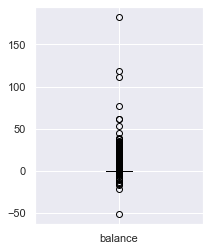

In [122]:
val_out(df_balance,'balance')

In [123]:
time_calc('Balance des paiements')
t = time.time()

Durée de l'opération 'Balance des paiements': 3.32 s
Durée totale de traitement: 00 h 00 m 16 s


##### Types de paiement

In [124]:
df_order_payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

In [125]:
df_order_payments.groupby('payment_type').count()

,order_id,payment_sequential,payment_installments,payment_value
payment_type,,,,
boleto,19784,19784,19784,19784
credit_card,76795,76795,76795,76795
debit_card,1529,1529,1529,1529
not_defined,3,3,3,3
voucher,5775,5775,5775,5775


In [126]:
df_order_payments[df_order_payments['order_id'] == '654da57158d96035814657b5143bb11b']

,order_id,payment_sequential,payment_type,payment_installments,payment_value
6506,654da57158d96035814657b5143bb11b,3,voucher,1,54.03
7698,654da57158d96035814657b5143bb11b,10,voucher,1,52.02
15266,654da57158d96035814657b5143bb11b,8,voucher,1,51.90
20445,654da57158d96035814657b5143bb11b,5,voucher,1,19.32
27836,654da57158d96035814657b5143bb11b,6,voucher,1,15.15
40495,654da57158d96035814657b5143bb11b,2,voucher,1,14.69
47607,654da57158d96035814657b5143bb11b,11,voucher,1,30.16
48504,654da57158d96035814657b5143bb11b,9,voucher,1,38.20
56346,654da57158d96035814657b5143bb11b,1,voucher,1,11.55
68192,654da57158d96035814657b5143bb11b,4,voucher,1,22.40


In [127]:
time_calc('Fusion 5: Commandes / Paiements')
t = time.time()

Durée de l'opération 'Fusion 5: Commandes / Paiements': 0.1 s
Durée totale de traitement: 00 h 00 m 16 s


## Modèle de données <a class="anchor" id="mod_don"></a>

In [128]:
df_customers_orders_products_payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 23 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   customer_id                    112650 non-null  object 
 1   customer_unique_id             112650 non-null  object 
 2   customer_zip_code_prefix       112650 non-null  int64  
 3   geolocation_zip_code_prefix_x  112348 non-null  float64
 4   order_id                       112650 non-null  object 
 5   order_status                   112650 non-null  object 
 6   order_purchase_timestamp       112650 non-null  object 
 7   score_mean_per_ord             112650 non-null  float64
 8   score_count_per_ord            112650 non-null  int64  
 9   score_mean_per_cust            112650 non-null  float64
 10  order_item_id                  112650 non-null  int64  
 11  product_id                     112650 non-null  object 
 12  seller_id                     

In [129]:
df = df_customers_orders_products_payments.sort_values(['customer_unique_id','order_id','order_purchase_timestamp'],
                                                   ascending = [True, True, False])

In [130]:
# Exemple: client avec plusieurs commandes
df[df['customer_unique_id'] == '32ea3bdedab835c3aa6cb68ce66565ef']

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_zip_code_prefix_x,order_id,order_status,order_purchase_timestamp,score_mean_per_ord,score_count_per_ord,score_mean_per_cust,...,seller_zip_code_prefix,geolocation_zip_code_prefix_y,product_category,price_total,price_per_ord,items_count,price_per_cust,prod_nb_avg,payment_sum_per_ord,payment_count_per_ord
13456,ce0ae5c05efa10263bab504ec83c6a92,32ea3bdedab835c3aa6cb68ce66565ef,4106,4106.0,30ae6774935cd2a70fa74306f407495b,delivered,2017-09-27 08:20:09,5.0,1,4.666667,...,5849,5849.0,watches_gifts,56.78,56.78,1,45.72,1.0,56.78,2.0
13455,355077684019f7f60a031656bd7262b8,32ea3bdedab835c3aa6cb68ce66565ef,4106,4106.0,3b697a20d9e427646d92567910af6d57,delivered,2016-10-03 09:44:50,4.0,1,4.666667,...,85801,85801.0,watches_gifts,45.46,45.46,1,45.72,1.0,45.46,1.0
13454,78dbb0a0c4b3d6ca743616323a56c47b,32ea3bdedab835c3aa6cb68ce66565ef,4106,4106.0,ebf144597fc5b016fb405d0fea5c9e2d,delivered,2018-06-28 11:46:04,5.0,1,4.666667,...,7032,7032.0,stationery,34.92,34.92,1,45.72,1.0,34.92,1.0


In [131]:
# Exemple: client avec une seule commande comprenant 3 fois le même prouit
df[df['customer_unique_id'] == '3de675e6f79e135540ee0144844d26a7']

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_zip_code_prefix_x,order_id,order_status,order_purchase_timestamp,score_mean_per_ord,score_count_per_ord,score_mean_per_cust,...,seller_zip_code_prefix,geolocation_zip_code_prefix_y,product_category,price_total,price_per_ord,items_count,price_per_cust,prod_nb_avg,payment_sum_per_ord,payment_count_per_ord
2221,af3e2512698db57266bf9f5e5aba537d,3de675e6f79e135540ee0144844d26a7,83321,83321.0,b72eceaf3e014a8336da6b52928715f2,delivered,2017-06-26 15:08:20,5.0,1,5.0,...,83321,83321.0,office_furniture,158.45,475.35,3,475.35,3.0,475.35,1.0
2222,af3e2512698db57266bf9f5e5aba537d,3de675e6f79e135540ee0144844d26a7,83321,83321.0,b72eceaf3e014a8336da6b52928715f2,delivered,2017-06-26 15:08:20,5.0,1,5.0,...,83321,83321.0,office_furniture,158.45,475.35,3,475.35,3.0,475.35,1.0
2223,af3e2512698db57266bf9f5e5aba537d,3de675e6f79e135540ee0144844d26a7,83321,83321.0,b72eceaf3e014a8336da6b52928715f2,delivered,2017-06-26 15:08:20,5.0,1,5.0,...,83321,83321.0,office_furniture,158.45,475.35,3,475.35,3.0,475.35,1.0


In [132]:
# Exemple: localisations de vendeur et livraison différentes
df[df['customer_unique_id'] == '004b45ec5c64187465168251cd1c9c2f']

,customer_id,customer_unique_id,customer_zip_code_prefix,geolocation_zip_code_prefix_x,order_id,order_status,order_purchase_timestamp,score_mean_per_ord,score_count_per_ord,score_mean_per_cust,...,seller_zip_code_prefix,geolocation_zip_code_prefix_y,product_category,price_total,price_per_ord,items_count,price_per_cust,prod_nb_avg,payment_sum_per_ord,payment_count_per_ord
83617,49cf243e0d353cd418ca77868e24a670,004b45ec5c64187465168251cd1c9c2f,57055,57055.0,90ae229a4addcfead792e2564554f09c,shipped,2017-09-01 12:11:23,1.0,1,3.0,...,15025,15025.0,garden_tools,97.87,97.87,1,73.86,1.0,97.87,1.0
83618,d95f60d70d9ea9a7fe37c53c931940bb,004b45ec5c64187465168251cd1c9c2f,57035,57035.0,9392c5e72885ad5aba87e6223ca9838d,delivered,2018-05-26 19:42:48,5.0,1,3.0,...,3204,3204.0,furniture_decor,49.85,49.85,1,73.86,1.0,49.85,1.0


In [133]:
# Exemple: localisations de vendeur et livraison différentes
df_cust_export = df[df['customer_unique_id'] == '3e43e6105506432c953e165fb2acf44c']

In [134]:
time_calc('Modèle de données - Initialisation')
t = time.time()

Durée de l'opération 'Modèle de données - Initialisation': 0.92 s
Durée totale de traitement: 00 h 00 m 17 s


### Traitement des données <a class="anchor" id="tra_don"></a>

#### Localisation

Il existe 2 niveaux de localisation:

1. Niveau Commande
2. Niveau Ligne de commande (item)

A chaque commande est associée un code de localisation (**'customer_zip_code_prefix'**).

Donc, un client unique peut se voir assigner plusieurs codes de localisation différents.

> Dans ce cas, le code **'customer_zip_code_prefix'** ne définit pas la localisation des clients mais plutôt la localisation de **livraison** des commandes.

Un code de localisation défini par la variable **'seller_zip_code_prefix'** est associé à chaque ligne de commande comprenant un numéro de commande et un numéro de produit.

> Dans ce cas, le code **'seller_zip_code_prefix'** correspond à la localisation du **vendeur** du produit concerné.

In [135]:
df_ord_loc_dif = df.groupby('customer_unique_id').agg({'customer_zip_code_prefix': 'count',
                                                       'customer_zip_code_prefix': pd.Series.nunique})
df_ord_loc_dif = df_ord_loc_dif[df_ord_loc_dif['customer_zip_code_prefix'] != 1]

In [136]:
loc_dif = df_ord_loc_dif.shape[0]
cust_unique = df['customer_unique_id'].unique().shape[0]

In [137]:
Markdown("""
On notera que, pour une large proportion de clients,
les localisations de livraison des commandes sont identiques pour toutes les commandes d'un même client.

> Il y a en effet **{loc_dif}** clients uniques (sur **{cust_unique}**) qui ont fait des commandes avec des localisations de livraison
différentes selon les commandes. 
""".format(loc_dif=loc_dif,cust_unique=cust_unique))


On notera que, pour une large proportion de clients,
les localisations de livraison des commandes sont identiques pour toutes les commandes d'un même client.

> Il y a en effet **245** clients uniques (sur **95420**) qui ont fait des commandes avec des localisations de livraison
différentes selon les commandes. 


Exemples:

In [138]:
df[['order_id','customer_zip_code_prefix','product_id','seller_zip_code_prefix']].sort_values(['order_id','customer_zip_code_prefix']).head()

,order_id,customer_zip_code_prefix,product_id,seller_zip_code_prefix
76051,00010242fe8c5a6d1ba2dd792cb16214,28013,4244733e06e7ecb4970a6e2683c13e61,27277
40786,00018f77f2f0320c557190d7a144bdd3,15775,e5f2d52b802189ee658865ca93d83a8f,3471
41579,000229ec398224ef6ca0657da4fc703e,35661,c777355d18b72b67abbeef9df44fd0fd,37564
60746,00024acbcdf0a6daa1e931b038114c75,12952,7634da152a4610f1595efa32f14722fc,14403
9282,00042b26cf59d7ce69dfabb4e55b4fd9,13226,ac6c3623068f30de03045865e4e10089,87900


In [139]:
time_calc('Modèle de données - Localisation 1')
t = time.time()

Durée de l'opération 'Modèle de données - Localisation 1': 8.06 s
Durée totale de traitement: 00 h 00 m 25 s


##### Localisation de livraison vs Localisation du vendeur

On cherche à savoir si il existe un lien entre la localisation des **vendeurs** et des **livraisons**.

Pour cela on compare dans un premier temps les localisations au niveau des lignes de commandes.

In [140]:
# On créé une variable 'same_loc' qui prend la valeur 1 quand les variables à comparer sont égales, 0 sinon
df['same_loc'] = df['customer_zip_code_prefix'] == df['seller_zip_code_prefix']

Exemples de clients pours lesquels la localisation de livraison est **égale** à la localisation du vendeur.

In [141]:
df[df['same_loc'] == True][['customer_unique_id','order_id','order_item_id','customer_zip_code_prefix',
                            'seller_zip_code_prefix','same_loc']].sort_values(['customer_unique_id','order_id']).head()

,customer_unique_id,order_id,order_item_id,customer_zip_code_prefix,seller_zip_code_prefix,same_loc
15294,0c184b7e23f30243d8957a97ce6af3f8,4d5e865e4b64c8b33f8a81fd14731344,1,80230,80230,True
86705,0d4cf36ed65cd1aba4a30a3bea1b19d4,3cfcc0ca272d41bdfa5d2ec747019f73,1,89560,89560,True
22152,1dbacfbc8a8b1ef3409ab799d372eeb2,aaf8c4fd10324c24379e08159ce8489e,1,14600,14600,True
22001,377c26c9b730b15b237991e2ec5a04d3,6a87a0371f263aa8c1779c2c115c1427,1,35570,35570,True
2221,3de675e6f79e135540ee0144844d26a7,b72eceaf3e014a8336da6b52928715f2,1,83321,83321,True


Exemples de clients pours lesquels la localisation de livraison est **différente** de la localisation du vendeur.

In [142]:
df[df['same_loc'] == False][['customer_unique_id','order_id','order_item_id','customer_zip_code_prefix',
                             'seller_zip_code_prefix','same_loc']].sort_values(['customer_unique_id','order_id']).head()

,customer_unique_id,order_id,order_item_id,customer_zip_code_prefix,seller_zip_code_prefix,same_loc
74356,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,1,7787,13405,False
29474,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,1,6053,2215,False
48314,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,1,88115,13232,False
66721,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,1,66812,3569,False
93084,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,1,18040,12327,False


> On exploitera la variable **'same_loc'** plus loin dans l'analyse.

In [143]:
time_calc('Modèle de données - Localisation 2')
t = time.time()

Durée de l'opération 'Modèle de données - Localisation 2': 0.49 s
Durée totale de traitement: 00 h 00 m 26 s


##### Localisation des clients

Un client unique peut se voir assigner plusieurs code de localisations liés aux commandes comme on peut le voir dans l'exemple ci-dessous.

In [144]:
df[df['customer_unique_id'] == '3e43e6105506432c953e165fb2acf44c'].sort_values('customer_zip_code_prefix')[['customer_unique_id','order_id','customer_zip_code_prefix','product_id']].sort_values('customer_zip_code_prefix') 

,customer_unique_id,order_id,customer_zip_code_prefix,product_id
6258,3e43e6105506432c953e165fb2acf44c,1124c329070977fbd414f046bba149d7,11700,689a9f33ae479ec0d9f68a9b6b0cfcbf
6253,3e43e6105506432c953e165fb2acf44c,826b47e4cd7bba4e4c6fa5485f898b74,11700,446607005fbc439a9439caed96867e26
6254,3e43e6105506432c953e165fb2acf44c,826b47e4cd7bba4e4c6fa5485f898b74,11700,82254d93b897fde054504b15f8fe923c
6251,3e43e6105506432c953e165fb2acf44c,e23ad32d5c15d9ad308baddc6262afea,11700,957f6d6b55b78746f89e976cba785440
6256,3e43e6105506432c953e165fb2acf44c,70863e8ef99613bbc8f854807d187ea7,11701,ceeb8b2d571b23399910f1b83980c973
6257,3e43e6105506432c953e165fb2acf44c,70863e8ef99613bbc8f854807d187ea7,11701,d296d7996d75ec35fcfc75b3a06cae63
6260,3e43e6105506432c953e165fb2acf44c,ed0b6f8c8617370e53735a5d963bb5b6,11701,7b49e585ac8c80b14c9b2815d4db465f
6261,3e43e6105506432c953e165fb2acf44c,ed0b6f8c8617370e53735a5d963bb5b6,11701,7b49e585ac8c80b14c9b2815d4db465f
6262,3e43e6105506432c953e165fb2acf44c,ed0b6f8c8617370e53735a5d963bb5b6,11701,1269d60fc5efbcf03e7eea49213091c6
6263,3e43e6105506432c953e165fb2acf44c,ed0b6f8c8617370e53735a5d963bb5b6,11701,55363f487ca324087a49ddfcfb91b971


> On souhaite associer une valeur unique de localisation à chaque client unique.

Le dataframe **df** inclut les clients, commandes, lignes de commandes et produits.

Dans l'exemple ci-dessus, les commandes sont donc dupliquées en autant de lignes de commandes (produits).

On s'intéresse aux valeurs uniques de localisation par commande.

Dans l'exemple ci-dessous, chaque valeurs de localisation distincte est représentée autant de fois qu'indexée dans une commande:
+ 3 commandes: 11700
+ 5 commandes: 11701
+ 1 commande: 11704

In [145]:
customer_unique_id_ex1 = '3e43e6105506432c953e165fb2acf44c'
customer_unique_id_ex2 = '9832ae2f7d3e5fa4c7a1a06e9551bc61'

customer_unique_id_ex = customer_unique_id_ex1

In [146]:
df_customers[df_customers['customer_unique_id'] == customer_unique_id_ex].sort_values('customer_zip_code_prefix')[['customer_unique_id','customer_zip_code_prefix']].sort_values('customer_zip_code_prefix') 

,customer_unique_id,customer_zip_code_prefix
6129,3e43e6105506432c953e165fb2acf44c,11700
10685,3e43e6105506432c953e165fb2acf44c,11700
64987,3e43e6105506432c953e165fb2acf44c,11700
5113,3e43e6105506432c953e165fb2acf44c,11701
8657,3e43e6105506432c953e165fb2acf44c,11701
50029,3e43e6105506432c953e165fb2acf44c,11701
89979,3e43e6105506432c953e165fb2acf44c,11701
90706,3e43e6105506432c953e165fb2acf44c,11701
20597,3e43e6105506432c953e165fb2acf44c,11704


Ce client se voit donc assigner 3 code de localisation.

On choisit arbitrairement de retenir la valeur la plus représentée, ici 11701.

In [147]:
df_cust_loc = df_customers[['customer_unique_id','customer_zip_code_prefix']].groupby('customer_unique_id').agg(lambda x:x.value_counts().index[0])

In [148]:
df_cust_loc.columns = ['customer_u_zip_code_prefix']
df_cust_loc.head()

,customer_u_zip_code_prefix
customer_unique_id,
0000366f3b9a7992bf8c76cfdf3221e2,7787
0000b849f77a49e4a4ce2b2a4ca5be3f,6053
0000f46a3911fa3c0805444483337064,88115
0000f6ccb0745a6a4b88665a16c9f078,66812
0004aac84e0df4da2b147fca70cf8255,18040


On trouve la valeur attendue dans l'exemple.

In [149]:
df_cust_loc = df_cust_loc.reset_index()
df_cust_loc[df_cust_loc['customer_unique_id'] == customer_unique_id_ex]

,customer_unique_id,customer_u_zip_code_prefix
23472,3e43e6105506432c953e165fb2acf44c,11701


In [150]:
df_cust_loc.shape

(96096, 2)

In [151]:
time_calc('Modèle de données - Localisation 3')
t = time.time()

Durée de l'opération 'Modèle de données - Localisation 3': 66.93 s
Durée totale de traitement: 00 h 01 m 33 s


#### cust_loc vs geolocation_gr

Maintenant que nous disposons d'un code de localisation par client unique, nous pouvons y associer les coordonnées géographiques.

In [152]:
data_model_2(df_cust_loc,df_geolocation_gr,
             'customer_u_zip_code_prefix','geolocation_gr',
             'customer_u_zip_code_prefix','geolocation_zip_code_prefix')

Nombre d'enregistrements du dataset 'customer_u_zip_code_prefix' non renseignés dans le dataset 'geolocation_gr': 269
Nombre d'enregistrements du dataset 'geolocation_gr' non renseignés dans le dataset 'customer_u_zip_code_prefix': 4185


Les clients uniques n'ont pas tous de correspondance dans le dataset ***'geolocation_gr'***.

> On fusionne donc les datasets ***cust_loc*** et ***geolocation_gr*** avec une contrainte de correspondance facultative sur ***geolocation_gr***  (left join).

In [153]:
df_cust_loc = df_cust_loc.merge(df_geolocation_gr, left_on = 'customer_u_zip_code_prefix', right_on = 'geolocation_zip_code_prefix', how = 'left')

In [154]:
df_cust_loc.head()

,customer_unique_id,customer_u_zip_code_prefix,geolocation_zip_code_prefix
0,0000366f3b9a7992bf8c76cfdf3221e2,7787,7787.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,6053,6053.0
2,0000f46a3911fa3c0805444483337064,88115,88115.0
3,0000f6ccb0745a6a4b88665a16c9f078,66812,66812.0
4,0004aac84e0df4da2b147fca70cf8255,18040,18040.0


Ci-dessous, des clients pour lesquels le code de localisation n'est pas référencé dans le dataset ***geolocation_gr***.

In [155]:
df_cust_loc.sort_values('geolocation_zip_code_prefix').tail()

,customer_unique_id,customer_u_zip_code_prefix,geolocation_zip_code_prefix
93221,f83ac6015ad3b37d4f96603f362cb14e,72280,NaN
93747,f9a19bbde55fdbb899189f8c71272570,72280,NaN
94141,fac8b5e914037fc2e2476783585f0769,65137,NaN
94317,fb3d2759405ec9a4a3e8eb61653a0bec,72005,NaN
94482,fbb25ad1452fbf7e073a084f8c2cbda6,73081,NaN


In [156]:
%store df_cust_loc

Stored 'df_cust_loc' (DataFrame)


In [157]:
data_model(df,'df','customer_id')
data_model(df,'df','customer_unique_id')
data_model(df_cust_loc,'df_cust_loc','customer_unique_id',1,3)

,Dataset,Shape,Variable,Duplicates,Unique,Null
25,df,112650,customer_id,13984,98666,0
26,df,112650,customer_unique_id,17230,95420,0
27,df_cust_loc,96096,customer_unique_id,0,96096,0


On ajoute la variable **'customer_u_zip_code_prefix'** du dataframe ***df_cust_loc*** au dataframe ***df***.

In [158]:
df = df.merge(df_cust_loc, left_on = 'customer_unique_id', right_on = 'customer_unique_id', how = 'left')

On renomme les variables de geolocalisation relatives aux clients, clients uniques et vendeurs.

In [159]:
# Variable de geolocalisation relative aux clients
df = df.rename(columns={('geolocation_zip_code_prefix_x'): 'customer_zip_code_prefix_gl'}, inplace = False)
# Variable de geolocalisation relative aux vendeurs
df = df.rename(columns={('geolocation_zip_code_prefix_y'): 'seller_zip_code_prefix_gl'}, inplace = False)
# Variable de geolocalisation relative aux clients uniques
df = df.rename(columns={('geolocation_zip_code_prefix'): 'customer_u_zip_code_prefix_gl'}, inplace = False)

In [160]:
time_calc('Modèle de données - Localisation 4')
t = time.time()

Durée de l'opération 'Modèle de données - Localisation 4': 1.07 s
Durée totale de traitement: 00 h 01 m 34 s


#### Format de date

On modifie le format de la variable **'order_purchase_timestamp'**.

In [161]:
# On créé une liste avec les valeurs de la variable 'order_purchase_timestamp'
list_purchase_date = df['order_purchase_timestamp'].values.tolist()

# Pour chaque valeur de la liste, on récupère les 10 premiers caractères
# Puis on supprime les '-'
for i in range(0,len(list_purchase_date)):
    list_purchase_date[i] = list_purchase_date[i][:10]
    list_purchase_date[i] = list_purchase_date[i].replace('-','')

# On créé une colonne 'date_rec' avec la liste list_purchase_date
df['purchase_date'] = list_purchase_date

# On convertit la variable 'date_rec' au format date
df['purchase_date'] = pd.to_datetime(df['purchase_date'], format='%Y%m%d')

# On supprime la variable 'order_purchase_timestamp'
del df['order_purchase_timestamp']

In [162]:
time_calc('Format de dates')
t = time.time()

Durée de l'opération 'Format de dates': 0.16 s
Durée totale de traitement: 00 h 01 m 34 s


### Dataframe df - Niveau Lignes de commandes <a class="anchor" id="dat_df"></a>

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    112650 non-null  object        
 1   customer_unique_id             112650 non-null  object        
 2   customer_zip_code_prefix       112650 non-null  int64         
 3   customer_zip_code_prefix_gl    112348 non-null  float64       
 4   order_id                       112650 non-null  object        
 5   order_status                   112650 non-null  object        
 6   score_mean_per_ord             112650 non-null  float64       
 7   score_count_per_ord            112650 non-null  int64         
 8   score_mean_per_cust            112650 non-null  float64       
 9   order_item_id                  112650 non-null  int64         
 10  product_id                     112650 non-null  object        
 11  


Affichage des 10 premières variables triées par taux croissant:

                               Taux de remplissage (%)
customer_u_zip_code_prefix_gl                   99.731
customer_zip_code_prefix_gl                     99.732
seller_zip_code_prefix_gl                       99.775
payment_count_per_ord                           99.997
payment_sum_per_ord                             99.997
customer_id                                    100.000
customer_u_zip_code_prefix                     100.000
same_loc                                       100.000
prod_nb_avg                                    100.000
price_per_cust                                 100.000


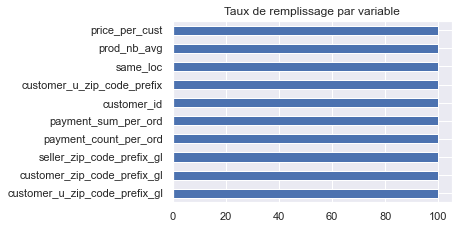

In [164]:
fill_rate(df,0,1,10)

#### Traitement des données catégorielles - Niveau Lignes de commandes

##### Catégories de produits

In [165]:
X = df[['product_category']]

In [166]:
X.head()

,product_category
0,bed_bath_table
1,health_beauty
2,stationery
3,telephony
4,telephony


In [167]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',sparse=True)

In [168]:
df_X_bin = pd.DataFrame(enc.fit_transform(X).todense())
df_X_bin.columns = enc.get_feature_names()
df = df.merge(df_X_bin, left_index=True, right_index=True, how = 'inner')
list_cat = df_X_bin.columns.tolist()
list_cat[0:5]

['x0_agro_industry_and_commerce',
 'x0_air_conditioning',
 'x0_art',
 'x0_arts_and_craftmanship',
 'x0_audio']

In [169]:
len(list_cat)

74

Ci-dessous un extrait de ***df*** pour illustration.

In [170]:
df_ex = df[(df['customer_unique_id'] == '000fbf0473c10fc1ab6f8d2d286ce20c') | 
   (df['customer_unique_id'] == '0000366f3b9a7992bf8c76cfdf3221e2')][['customer_unique_id',
    'product_category','x0_bed_bath_table','x0_musical_instruments','x0_toys','x0_audio']].sort_values('customer_unique_id')
df_ex.reset_index(inplace=True)
del df_ex['index']
df_ex

,customer_unique_id,product_category,x0_bed_bath_table,x0_musical_instruments,x0_toys,x0_audio
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table,1.0,0.0,0.0,0.0
1,000fbf0473c10fc1ab6f8d2d286ce20c,musical_instruments,0.0,1.0,0.0,0.0
2,000fbf0473c10fc1ab6f8d2d286ce20c,musical_instruments,0.0,1.0,0.0,0.0
3,000fbf0473c10fc1ab6f8d2d286ce20c,toys,0.0,0.0,1.0,0.0
4,000fbf0473c10fc1ab6f8d2d286ce20c,toys,0.0,0.0,1.0,0.0


In [171]:
df.shape

(112650, 100)

In [172]:
%store df

Stored 'df' (DataFrame)


In [173]:
time_calc('Encodage - Catégories de produits')
t = time.time()

Durée de l'opération 'Encodage - Catégories de produits': 1.47 s
Durée totale de traitement: 00 h 01 m 36 s


### Dataframe df1 - Niveau Client <a class="anchor" id="dat_df1"></a>

In [174]:
df1 = df.groupby('customer_unique_id').agg({'purchase_date': ['min','max'],
                                            'order_id': pd.Series.nunique,
                                            'product_id': 'count',
                                            'price_total': ['mean','sum'],
                                            'price_per_cust': 'first',
                                            'prod_nb_avg': 'first',
                                            'score_mean_per_ord': 'mean',
                                            'score_mean_per_cust': 'first',
                                            'same_loc': 'sum',
                                            'customer_u_zip_code_prefix': 'first'})
df1.columns.tolist()

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_ord', 'mean'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 ('customer_u_zip_code_prefix', 'first')]

In [175]:
time_calc('Création df1')
t = time.time()

Durée de l'opération 'Création df1': 9.99 s
Durée totale de traitement: 00 h 01 m 46 s


#### Traitement des données catégorielles - Niveau Client

##### Catégories de produits

In [176]:
list_cat.append('customer_unique_id')
df_cat = df[list_cat]
# On regroupe les données par client unique et on agrège sur la valeur max de la variable catégorie de produit
# Ainsi, on assigne à chaque client les catégories de produits qu'il a commandé au moins une fois
df_cat = df_cat.groupby('customer_unique_id').max()
list_cat.remove('customer_unique_id')
df_cat[['x0_art','x0_bed_bath_table','x0_telephony','x0_audio']].head()

,x0_art,x0_bed_bath_table,x0_telephony,x0_audio
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,1.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,1.0,0.0


Ci-dessous un extrait de ***df_cat*** pour illustration.

In [177]:
df_cat_ex = df_cat.reset_index()
df_cat_ex[(df_cat_ex['customer_unique_id'] == '000fbf0473c10fc1ab6f8d2d286ce20c') | 
   (df_cat_ex['customer_unique_id'] == '0000366f3b9a7992bf8c76cfdf3221e2')][['customer_unique_id',
    'x0_bed_bath_table','x0_musical_instruments','x0_toys','x0_audio']]

,customer_unique_id,x0_bed_bath_table,x0_musical_instruments,x0_toys,x0_audio
0,0000366f3b9a7992bf8c76cfdf3221e2,1.0,0.0,0.0,0.0
22,000fbf0473c10fc1ab6f8d2d286ce20c,0.0,1.0,1.0,0.0


In [178]:
df_cat.shape

(95420, 74)

In [179]:
%store df_cat

Stored 'df_cat' (DataFrame)


In [180]:
time_calc('Catégories de produits par client')
t = time.time()

Durée de l'opération 'Catégories de produits par client': 0.77 s
Durée totale de traitement: 00 h 01 m 46 s


On calcule le nombre de produits différents achetés par les clients.

In [181]:
df_cat['nb_prod_diff'] = df_cat.sum(axis = 1)

In [182]:
df1 = df1.merge(df_cat[['nb_prod_diff']], left_index=True, right_index=True)
df1.columns.tolist()

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_ord', 'mean'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 ('customer_u_zip_code_prefix', 'first'),
 'nb_prod_diff']

In [183]:
df1['nb_prod_diff'] = np.int64(df1['nb_prod_diff'])

In [184]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 95420 entries, 0000366f3b9a7992bf8c76cfdf3221e2 to ffffd2657e2aad2907e67c3e9daecbeb
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   (purchase_date, min)                 95420 non-null  datetime64[ns]
 1   (purchase_date, max)                 95420 non-null  datetime64[ns]
 2   (order_id, nunique)                  95420 non-null  int64         
 3   (product_id, count)                  95420 non-null  int64         
 4   (price_total, mean)                  95420 non-null  float64       
 5   (price_total, sum)                   95420 non-null  float64       
 6   (price_per_cust, first)              95420 non-null  float64       
 7   (prod_nb_avg, first)                 95420 non-null  float64       
 8   (score_mean_per_ord, mean)           95420 non-null  float64       
 9   (score_mean_per_cust, first)  

In [185]:
df1.sort_values(('order_id', 'nunique'), ascending = False).head()

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_ord, mean)","(score_mean_per_cust, first)","(same_loc, sum)","(customer_u_zip_code_prefix, first)",nb_prod_diff
customer_unique_id,,,,,,,,,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,2017-05-15,2018-08-20,16,16,56.377500,902.04,56.377500,1.000000,5.000000,4.764706,0.0,4045,4
3e43e6105506432c953e165fb2acf44c,2017-09-18,2018-02-27,9,14,83.762143,1172.67,130.296667,1.555556,2.642857,2.777778,0.0,11701,5
1b6c7548a2a1f9037c1fd3ddfed95f33,2017-11-13,2018-02-14,7,9,106.556667,959.01,137.001429,1.285714,5.000000,5.000000,0.0,38301,5
6469f99c1f9dfae7733b25662e7f1782,2017-09-19,2018-06-28,7,9,84.314444,758.83,108.404286,1.285714,5.000000,5.000000,0.0,11065,1
ca77025e7201e3b30c44b472ff346268,2017-10-09,2018-06-01,7,12,93.560000,1122.72,160.388571,1.714286,5.000000,5.000000,0.0,51021,4


In [186]:
time_calc('Nombre de produits différents par client')
t = time.time()

Durée de l'opération 'Nombre de produits différents par client': 0.32 s
Durée totale de traitement: 00 h 01 m 47 s


##### Types de paiement

In [187]:
df_order_payments.shape

(103886, 5)

In [188]:
X = df_order_payments[['payment_type']]
X.head()

,payment_type
0,credit_card
1,credit_card
2,credit_card
3,credit_card
4,credit_card


In [189]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore',sparse=True)

In [190]:
df_X_bin = pd.DataFrame(enc.fit_transform(X).todense())
df_X_bin.columns = enc.get_feature_names()

df_pay_type = df_order_payments[['order_id']].merge(df_X_bin, left_index=True, right_index=True, how = 'inner')

list_pay_type = df_X_bin.columns.tolist()
list_pay_type[0:5]

['x0_boleto',
 'x0_credit_card',
 'x0_debit_card',
 'x0_not_defined',
 'x0_voucher']

In [191]:
len(list_pay_type)

5

In [192]:
df_pay_type.head()

,order_id,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
0,b81ef226f3fe1789b1e8b2acac839d17,0.0,1.0,0.0,0.0,0.0
1,a9810da82917af2d9aefd1278f1dcfa0,0.0,1.0,0.0,0.0,0.0
2,25e8ea4e93396b6fa0d3dd708e76c1bd,0.0,1.0,0.0,0.0,0.0
3,ba78997921bbcdc1373bb41e913ab953,0.0,1.0,0.0,0.0,0.0
4,42fdf880ba16b47b59251dd489d4441a,0.0,1.0,0.0,0.0,0.0


On regroupe les données par commande et on agrège sur la valeur max de la variable type de paiement.

Ainsi, on assigne à chaque commande les types de paiement utilisés pour cette commande.

In [193]:
df_pay_type = df_pay_type.groupby('order_id').max()

In [194]:
df_pay_type.reset_index(inplace=True)

In [195]:
df_pay_type.head()

,order_id,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
0,00010242fe8c5a6d1ba2dd792cb16214,0.0,1.0,0.0,0.0,0.0
1,00018f77f2f0320c557190d7a144bdd3,0.0,1.0,0.0,0.0,0.0
2,000229ec398224ef6ca0657da4fc703e,0.0,1.0,0.0,0.0,0.0
3,00024acbcdf0a6daa1e931b038114c75,0.0,1.0,0.0,0.0,0.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,0.0,1.0,0.0,0.0,0.0


In [196]:
df_pay_type.shape

(99440, 6)

In [197]:
df_customers_orders.shape

(99441, 10)

In [198]:
df1.head(2)

,"(purchase_date, min)","(purchase_date, max)","(order_id, nunique)","(product_id, count)","(price_total, mean)","(price_total, sum)","(price_per_cust, first)","(prod_nb_avg, first)","(score_mean_per_ord, mean)","(score_mean_per_cust, first)","(same_loc, sum)","(customer_u_zip_code_prefix, first)",nb_prod_diff
customer_unique_id,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10,2018-05-10,1,1,141.90,141.90,141.90,1.0,5.0,5.0,0.0,7787,1
0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07,2018-05-07,1,1,27.19,27.19,27.19,1.0,4.0,4.0,0.0,6053,1


On fusionne avec **df_customers_orders** afin d'obtenir le code client.

In [199]:
df_pay_type = df_pay_type.merge(df_customers_orders[['customer_unique_id','order_id']], left_on = 'order_id', right_on = 'order_id', how = 'right')

In [200]:
df_pay_type.head(2)

,order_id,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,0.0,1.0,0.0,0.0,0.0,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,0.0,1.0,0.0,0.0,0.0,eb28e67c4c0b83846050ddfb8a35d051


In [201]:
del df_pay_type['order_id']
df_pay_type.head()

,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher,customer_unique_id
0,0.0,1.0,0.0,0.0,0.0,871766c5855e863f6eccc05f988b23cb
1,0.0,1.0,0.0,0.0,0.0,eb28e67c4c0b83846050ddfb8a35d051
2,0.0,1.0,0.0,0.0,0.0,3818d81c6709e39d06b2738a8d3a2474
3,0.0,1.0,0.0,0.0,0.0,af861d436cfc08b2c2ddefd0ba074622
4,0.0,1.0,0.0,0.0,0.0,64b576fb70d441e8f1b2d7d446e483c5


On regroupe les données par client et on agrège sur la valeur max de la variable type de paiement.

Ainsi, on assigne à chaque client les types de paiement utilisés pour l'ensemble de ses commandes.

In [202]:
df_pay_type.shape

(99441, 6)

In [203]:
df_pay_type = df_pay_type.groupby('customer_unique_id').max()
df_pay_type.head()

,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,1.0,0.0,0.0,0.0
0000f46a3911fa3c0805444483337064,0.0,1.0,0.0,0.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,1.0,0.0,0.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,1.0,0.0,0.0,0.0


On a vu plus haut qu'une commande pouvait ne pas avoir de paiments associé.

La dataframe **df_pay_type** contient donc nécessairement une ou plusieurs lignes vides (NaN).

In [204]:
df_pay_type[df_pay_type['x0_boleto'].isna()]

,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
customer_unique_id,,,,,
830d5b7aaa3b6f1e9ad63703bec97d23,NaN,NaN,NaN,NaN,NaN


On remplace les valeurs nulles par 0, ainsi un client dont aucune commande n'a fait l'objet de paiement se verra assigner 0 pour tous les types de paiements.

In [205]:
df_pay_type.fillna(0, inplace=True)

In [206]:
df_pay_type.isna().sum().sum()

0

In [207]:
df_pay_type.head(2)

,x0_boleto,x0_credit_card,x0_debit_card,x0_not_defined,x0_voucher
customer_unique_id,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,1.0,0.0,0.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,1.0,0.0,0.0,0.0


In [208]:
df_pay_type.shape

(96096, 5)

In [209]:
%store df_pay_type

Stored 'df_pay_type' (DataFrame)


In [210]:
time_calc('Encodage - Types de paiement par client')
t = time.time()

Durée de l'opération 'Encodage - Types de paiement par client': 1.1 s
Durée totale de traitement: 00 h 01 m 48 s


On calcule le nombre de types de paiements différents utilisés par les clients.

In [211]:
df_pay_type['nb_pay_type_diff'] = df_pay_type.sum(axis = 1)

In [212]:
df1 = df1.merge(df_pay_type[['nb_pay_type_diff']], left_index=True, right_index=True)
df1.columns.tolist()

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_ord', 'mean'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 ('customer_u_zip_code_prefix', 'first'),
 'nb_prod_diff',
 'nb_pay_type_diff']

In [213]:
df1['nb_pay_type_diff'] = np.int64(df1['nb_pay_type_diff'])

In [214]:
df1.columns.tolist()

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_ord', 'mean'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 ('customer_u_zip_code_prefix', 'first'),
 'nb_prod_diff',
 'nb_pay_type_diff']

In [215]:
df1.shape

(95420, 14)

In [216]:
time_calc('Nombre de types de paiement par client')
t = time.time()

Durée de l'opération 'Nombre de types de paiement par client': 0.2 s
Durée totale de traitement: 00 h 01 m 48 s


##### Base de client finale (df1)

On mémorise la liste des variables de **df1** dans la liste **list_rfm**.

In [217]:
list_rfm = df1.columns.tolist()

In [218]:
list_rfm

[('purchase_date', 'min'),
 ('purchase_date', 'max'),
 ('order_id', 'nunique'),
 ('product_id', 'count'),
 ('price_total', 'mean'),
 ('price_total', 'sum'),
 ('price_per_cust', 'first'),
 ('prod_nb_avg', 'first'),
 ('score_mean_per_ord', 'mean'),
 ('score_mean_per_cust', 'first'),
 ('same_loc', 'sum'),
 ('customer_u_zip_code_prefix', 'first'),
 'nb_prod_diff',
 'nb_pay_type_diff']

On stocke la base de clients **df1** et la liste **list_rfm** pour usage ultérieur lors de la segmentation RFM et du clustering.

In [219]:
%store df1
%store list_rfm

Stored 'df1' (DataFrame)
Stored 'list_rfm' (list)


In [220]:
time_calc('Base de clients finale(df1)')
t = time.time()

Durée de l'opération 'Base de clients finale(df1)': 0.16 s
Durée totale de traitement: 00 h 01 m 48 s


### Fonctions de recherche par client <a class="anchor" id="fon_rec"></a>

On créé plusieurs fonctions permettant d'afficher les données relatives à un client.

In [221]:
list_cust_search = ['customer_unique_id', # Numéro de client unique                    

                    'order_id', # Numéro de commande
                    'purchase_date', # Date d'achat (liée à la commande)
                    #'order_status',
                    'order_item_id',
                    'product_id',
                    'product_category',
                    'price_total', # Prix total du produit (prix produit + frais de livraison)
                    
                    'score_mean_per_ord', # Review Score moyen par commande
                    'score_mean_per_cust', # Review Score moyen par client
                    
                    'seller_id',
                    
                    'customer_u_zip_code_prefix', # Localisation des clients uniques                    
                    'customer_zip_code_prefix', # Localisation de livraison (liée à la commande)
                    'seller_zip_code_prefix', # Localisation du vendeur (liée à la ligne de commande)              
                    'same_loc', # Localisation de livraison = localisation du vendeur (par ligne de commande)
                    ] 

# Résultats par client

def cust_search_1(customer_unique_id, order_sort = 0, date_sort = 0):
    
    df_cust_result_1 = df[df['customer_unique_id'] == customer_unique_id][list_cust_search]
    
    if order_sort == 0:
        df_cust_result_1 = df_cust_result_1.sort_values('order_id')
    elif order_sort == 1:
        df_cust_result_1 = df_cust_result_1.sort_values('order_id', ascending = False)
    if date_sort == 0:
        df_cust_result_1 = df_cust_result_1.sort_values('purchase_date')
    elif date_sort == 1:
        df_cust_result_1 = df_cust_result_1.sort_values('purchase_date', ascending = False)
            
    print ('Nombre de lignes:', df_cust_result_1.shape[0])
    
    return df_cust_result_1

# Résultats regroupés par client

def cust_search_2(customer_unique_id):
    
    df1b = df1.reset_index()
    df1b.columns = ['customer_unique_id','start','end','number of orders','number of products','average price','total price',
                    'average basket','product number average','score_mean_per_order','mean score','seller loc = delivery loc',
                    'customer loc','number of different products','nb_pay_type_diff']
    df1b = df1b[['customer_unique_id','start','end','number of orders','number of products','product number average',
                 'number of different products','average basket','average price','total price','nb_pay_type_diff',
                 'seller loc = delivery loc','mean score','customer loc']]
    
    df_cust_result_2 = df1b[df1b['customer_unique_id'] == customer_unique_id]
    
    return df_cust_result_2.T

**Recherche client 1**

In [222]:
customer_unique_id = '0a0a92112bd4c708ca5fde585afaa872'

cust_search_1(customer_unique_id)

Nombre de lignes: 8


,customer_unique_id,order_id,purchase_date,order_item_id,product_id,product_category,price_total,score_mean_per_ord,score_mean_per_cust,seller_id,customer_u_zip_code_prefix,customer_zip_code_prefix,seller_zip_code_prefix,same_loc
4494,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,1,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4495,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,2,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4496,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,3,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4497,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,4,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4498,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,5,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4499,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,6,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4500,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,7,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False
4501,0a0a92112bd4c708ca5fde585afaa872,03caa2c082116e1d31e67e9ae3700499,2017-09-29,8,5769ef0a239114ac3a854af00df129e4,fixed_telephony,1708.01,1.0,1.0,b37c4c02bda3161a7546a4e6d222d5b2,20080,20080,3667,False


In [223]:
cust_search_2(customer_unique_id)

,3799
customer_unique_id,0a0a92112bd4c708ca5fde585afaa872
start,2017-09-29 00:00:00
end,2017-09-29 00:00:00
number of orders,1
number of products,8
product number average,8
number of different products,1
average basket,13664.1
average price,1708.01
total price,13664.1


**Recherche client 2**

In [224]:
customer_unique_id = '8d50f5eadf50201ccdcedfb9e2ac8455'

cust_search_1(customer_unique_id)

Nombre de lignes: 16


,customer_unique_id,order_id,purchase_date,order_item_id,product_id,product_category,price_total,score_mean_per_ord,score_mean_per_cust,seller_id,customer_u_zip_code_prefix,customer_zip_code_prefix,seller_zip_code_prefix,same_loc
62004,8d50f5eadf50201ccdcedfb9e2ac8455,5d848f3d93a493c1c8955e018240e7ca,2017-05-15,1,4e1d2ef2974c85d82582edfe594a4f57,sports_leisure,22.77,5.0,4.764706,1da3aeb70d7989d1e6d9b0e887f97c23,4045,4045,4265,False
62001,8d50f5eadf50201ccdcedfb9e2ac8455,369634708db140c5d2c4e365882c443a,2017-06-18,1,d83509907a19c72e1e4cdde78b8177ec,sports_leisure,51.75,5.0,4.764706,94e93ce877be27a515118dbfd2c2be41,4045,4045,15502,False
62002,8d50f5eadf50201ccdcedfb9e2ac8455,4f62d593acae92cea3c5662c76122478,2017-07-18,1,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,21.77,5.0,4.764706,1da3aeb70d7989d1e6d9b0e887f97c23,4045,4045,4265,False
62010,8d50f5eadf50201ccdcedfb9e2ac8455,bf92c69b7cc70f7fc2c37de43e366173,2017-07-24,1,e01bc2ad5c6f46c0f53f73379fcd602e,sports_leisure,166.71,5.0,4.764706,a3a38f4affed601eb87a97788c949667,4045,4045,89204,False
62003,8d50f5eadf50201ccdcedfb9e2ac8455,519203404f6116d406a970763ee75799,2017-08-05,1,5fb61f482620cb672f5e586bb132eae9,other,81.89,5.0,4.764706,94e93ce877be27a515118dbfd2c2be41,4045,4045,15502,False
62014,8d50f5eadf50201ccdcedfb9e2ac8455,e3071b7624445af6e4f3a1b23718667d,2017-09-05,1,88159bac10e3d4f4b69b157406c7f70f,sports_leisure,51.75,5.0,4.764706,fdaaf5bfda82b7b80535610c831b8d09,4045,4045,15015,False
62012,8d50f5eadf50201ccdcedfb9e2ac8455,cd4b336a02aacabd0ef22f6db711f95e,2017-10-18,1,9169f70b7ce1138ac35678432d1e5ff2,sports_leisure,37.77,5.0,4.764706,1da3aeb70d7989d1e6d9b0e887f97c23,4045,4045,4265,False
62007,8d50f5eadf50201ccdcedfb9e2ac8455,89d9b111d2b990deb5f5f9769f92800b,2017-10-29,1,94cc774056d3f2b0dc693486a589025e,fashion_bags_accessories,21.77,5.0,4.764706,1da3aeb70d7989d1e6d9b0e887f97c23,4045,4045,4265,False
62009,8d50f5eadf50201ccdcedfb9e2ac8455,b850a16d8faf65a74c51287ef34379ce,2017-11-22,1,5bccc8fe44471df6c7b7e08176837d2f,sports_leisure,21.77,5.0,4.764706,1da3aeb70d7989d1e6d9b0e887f97c23,4045,4045,4265,False
62000,8d50f5eadf50201ccdcedfb9e2ac8455,23427a6bd9f8fd1b51f1b1e5cc186ab8,2018-05-21,1,5cb96c51c55f57503465e4d2558dc053,sports_leisure,53.38,5.0,4.764706,db4350fd57ae30082dec7acbaacc17f9,4045,4045,3126,False


**Recherche client 3**

In [225]:
customer_unique_id = '830d5b7aaa3b6f1e9ad63703bec97d23'

cust_search_1(customer_unique_id)

Nombre de lignes: 3


,customer_unique_id,order_id,purchase_date,order_item_id,product_id,product_category,price_total,score_mean_per_ord,score_mean_per_cust,seller_id,customer_u_zip_code_prefix,customer_zip_code_prefix,seller_zip_code_prefix,same_loc
57683,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09-15,1,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,47.82,1.0,1.0,ecccfa2bb93b34a3bf033cc5d1dcdc69,14600,14600,81810,False
57684,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09-15,2,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,47.82,1.0,1.0,ecccfa2bb93b34a3bf033cc5d1dcdc69,14600,14600,81810,False
57685,830d5b7aaa3b6f1e9ad63703bec97d23,bfbd0f9bdef84302105ad712db648a6c,2016-09-15,3,5a6b04657a4c5ee34285d1e4619a96b4,health_beauty,47.82,1.0,1.0,ecccfa2bb93b34a3bf033cc5d1dcdc69,14600,14600,81810,False


In [226]:
cust_search_2(customer_unique_id)

,48972
customer_unique_id,830d5b7aaa3b6f1e9ad63703bec97d23
start,2016-09-15 00:00:00
end,2016-09-15 00:00:00
number of orders,1
number of products,3
product number average,3
number of different products,1
average basket,143.46
average price,47.82
total price,143.46


In [227]:
time_calc('Fonctions recherche par client',1)
t = time.time()

Durée de l'opération 'Fonctions recherche par client': 0.31 s
Durée totale de traitement: 00 h 01 m 48 s

Durée des opérations
--------------------
                                       Opération  Durée
0                                 Initialisation   0.09
1                       Récupération des données   3.19
2              Fusion 1: Commandes / Evaluations   2.28
3                  Fusion 2: Clients / Commandes   2.84
4                     Fusion 3: Items / Produits   2.49
5   Fusion 4: Clients/Commandes / Items/Produits   2.63
6                          Balance des paiements   3.32
7                Fusion 5: Commandes / Paiements   0.10
8             Modèle de données - Initialisation   0.92
9             Modèle de données - Localisation 1   8.06
10            Modèle de données - Localisation 2   0.49
11            Modèle de données - Localisation 3  66.93
12            Modèle de données - Localisation 4   1.07
13                               Format de dates   0.16
14          